***Prueba de MIL con rsna usando features de ResNet-18***

In [1]:
import sys
print(sys.executable)

/home/javitrucas/miniconda3/envs/tfg/bin/python


In [2]:
import torch
import wandb
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import sys
import os

# Agregar el directorio raíz del proyecto a sys.path
project_root = "/home/javitrucas/TFG"
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from scripts.dataset_loader import load_dataset
from scripts.medical_scripts.medical_evaluation import ModelEvaluator
from scripts.medical_scripts.medical_training import Training
from scripts.MIL_utils import MIL_collate_fn

from types import SimpleNamespace
from box import Box

/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_results(results):
    """
    Visualiza las métricas de entrenamiento, validación y prueba.
    Los resultados deben contener claves específicas para cada métrica.
    """
    
    # 1. Matriz de confusión
    if "confusion_matrix" in results:
        cm = results["confusion_matrix"]
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.show()

    # 2. Curvas de pérdida (loss)
    if "train_loss_curve" in results or "val_loss_curve" in results or "test_loss_curve" in results:
        plt.figure(figsize=(10, 6))
        if "train_loss_curve" in results:
            plt.plot(results["train_loss_curve"], label="Training Loss", color="blue")
        if "val_loss_curve" in results:
            plt.plot(results["val_loss_curve"], label="Validation Loss", color="orange")
        if "test_loss_curve" in results:
            plt.plot(results["test_loss_curve"], label="Test Loss", color="green")
        plt.title("Loss Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid()
        plt.show()

    # 3. Curvas de precisión (accuracy)
    if "train_accuracy_curve" in results or "val_accuracy_curve" in results or "test_accuracy_curve" in results:
        plt.figure(figsize=(10, 6))
        if "train_accuracy_curve" in results:
            plt.plot(results["train_accuracy_curve"], label="Training Accuracy", color="blue")
        if "val_accuracy_curve" in results:
            plt.plot(results["val_accuracy_curve"], label="Validation Accuracy", color="orange")
        if "test_accuracy_curve" in results:
            plt.plot(results["test_accuracy_curve"], label="Test Accuracy", color="green")
        plt.title("Accuracy Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid()
        plt.show()

    # 4. F1-Score
    if "train_f1_score" in results or "val_f1_score" in results or "test_f1_score" in results:
        plt.figure(figsize=(10, 6))
        if "train_f1_score" in results:
            plt.plot(results["train_f1_score"], label="Training F1-Score", color="blue")
        if "val_f1_score" in results:
            plt.plot(results["val_f1_score"], label="Validation F1-Score", color="orange")
        if "test_f1_score" in results:
            plt.plot(results["test_f1_score"], label="Test F1-Score", color="green")
        plt.title("F1-Score Curves")
        plt.xlabel("Epochs")
        plt.ylabel("F1-Score")
        plt.legend()
        plt.grid()
        plt.show()

    # 5. AUC-ROC
    if "train_auc_roc" in results or "val_auc_roc" in results or "test_auc_roc" in results:
        plt.figure(figsize=(10, 6))
        if "train_auc_roc" in results:
            plt.plot(results["train_auc_roc"], label="Training AUC-ROC", color="blue")
        if "val_auc_roc" in results:
            plt.plot(results["val_auc_roc"], label="Validation AUC-ROC", color="orange")
        if "test_auc_roc" in results:
            plt.plot(results["test_auc_roc"], label="Test AUC-ROC", color="green")
        plt.title("AUC-ROC Curves")
        plt.xlabel("Epochs")
        plt.ylabel("AUC-ROC")
        plt.legend()
        plt.grid()
        plt.show()

    # 6. Precision
    if "train_precision" in results or "val_precision" in results or "test_precision" in results:
        plt.figure(figsize=(10, 6))
        if "train_precision" in results:
            plt.plot(results["train_precision"], label="Training Precision", color="blue")
        if "val_precision" in results:
            plt.plot(results["val_precision"], label="Validation Precision", color="orange")
        if "test_precision" in results:
            plt.plot(results["test_precision"], label="Test Precision", color="green")
        plt.title("Precision Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid()
        plt.show()

    # 7. Recall
    if "train_recall" in results or "val_recall" in results or "test_recall" in results:
        plt.figure(figsize=(10, 6))
        if "train_recall" in results:
            plt.plot(results["train_recall"], label="Training Recall", color="blue")
        if "val_recall" in results:
            plt.plot(results["val_recall"], label="Validation Recall", color="orange")
        if "test_recall" in results:
            plt.plot(results["test_recall"], label="Test Recall", color="green")
        plt.title("Recall Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Recall")
        plt.legend()
        plt.grid()
        plt.show()

    # 8. AUROC (Area Under the Receiver Operating Characteristic Curve)
    if "train_auroc" in results or "val_auroc" in results or "test_auroc" in results:
        plt.figure(figsize=(10, 6))
        if "train_auroc" in results:
            plt.plot(results["train_auroc"], label="Training AUROC", color="blue")
        if "val_auroc" in results:
            plt.plot(results["val_auroc"], label="Validation AUROC", color="orange")
        if "test_auroc" in results:
            plt.plot(results["test_auroc"], label="Test AUROC", color="green")
        plt.title("AUROC Curves")
        plt.xlabel("Epochs")
        plt.ylabel("AUROC")
        plt.legend()
        plt.grid()
        plt.show()

    # 9. Learning Rate (si está disponible)
    if "learning_rate" in results:
        plt.figure(figsize=(10, 6))
        plt.plot(results["learning_rate"], label="Learning Rate", color="purple")
        plt.title("Learning Rate Schedule")
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.legend()
        plt.grid()
        plt.show()

        # Curvas de entrenamiento y validación
        plt.figure(figsize=(10, 5))
        plt.plot(results["train_loss_curve"], label="Training Loss")
        plt.plot(results["val_loss_curve"], label="Validation Loss")
        plt.title("Loss Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 5))
        plt.plot(results["train_accuracy_curve"], label="Training Accuracy")
        plt.plot(results["val_accuracy_curve"], label="Validation Accuracy")
        plt.title("Accuracy Curves")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

        # Métricas de prueba (escalares)
        print("\n--- Test Results ---")
        print(f"Accuracy: {results['test_metrics']['accuracy']:.4f}")
        print(f"AUC: {results['test_metrics']['auc']:.4f}")
        print(f"F1-Score: {results['test_metrics']['f1_score']:.4f}")
        print(f"Precision: {results['test_metrics']['precision']:.4f}")
        print(f"Recall: {results['test_metrics']['recall']:.4f}")
        
        # Matriz de confusión
        if "confusion_matrix" in results['test_metrics']:
            cm = results['test_metrics']["confusion_matrix"]
            plt.figure(figsize=(8, 6))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title("Confusion Matrix (Test)")
            plt.xlabel("Predicted")
            plt.ylabel("True")
            plt.show()

In [7]:
def run_experiment(config):
    # Crear un objeto temporal para compatibilidad
    class TempConfig:
        def __init__(self, config_dict):
            self.__dict__.update(config_dict)

    config_obj = TempConfig(config)

    # Iniciar wandb
    wandb.init(
        project="TFG",
        config=config
    )

    # Parámetros controlados desde la configuración
    dataset_name = config_obj.dataset_name
    num_epochs = config_obj.num_epochs
    learning_rate = config_obj.learning_rate
    batch_size = config_obj.batch_size
    pooling_type = config_obj.pooling_type       # Nuevo parámetro
    input_feature_dim = config_obj.input_feature_dim  # Nuevo parámetro
    feature_dim = config_obj.feature_dim         # Nuevo parámetro

    # Directorio para guardar modelos
    output_model_dir = f"./models/{dataset_name.split('-')[0]}"
    os.makedirs(output_model_dir, exist_ok=True)

    # Cargar datasets
    train_dataset, val_dataset = load_dataset(config=config, mode="train_val")
    test_dataset = load_dataset(config=config, mode="test")

    # Crear dataloaders
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=MIL_collate_fn)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=MIL_collate_fn)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=MIL_collate_fn)

    # Iniciar el entrenamiento
    trainer = Training(
        train_loader=train_loader,
        val_loader=val_loader,
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        output_model_dir=output_model_dir,
        pooling_type=pooling_type,              # Pasar pooling_type
        input_feature_dim=input_feature_dim,    # Pasar input_feature_dim
        feature_dim=feature_dim,                # Pasar feature_dim
        wandb=wandb
    )
    trainer.train()

    # Guardar el modelo correctamente antes de evaluarlo
    model_path = os.path.join(output_model_dir, 'model.pth')
    torch.save(trainer.model.state_dict(), model_path)  # Asegurar que el modelo se guarda

    # Verificar que el archivo se haya guardado correctamente
    if not os.path.isfile(model_path):
        raise ValueError(f"El modelo no se guardó correctamente en: {model_path}")

    # Guardar el modelo como un artefacto en wandb
    artifact = wandb.Artifact('model', type='model')
    artifact.add_file(model_path)
    wandb.log_artifact(artifact)

    # Iniciar la evaluación
    evaluator = ModelEvaluator(
        model_path=model_path,
        test_loader=test_loader,
        batch_size=batch_size,
        input_feature_dim=input_feature_dim,  
        feature_dim=feature_dim,              
        pooling_type=pooling_type,
        wandb=wandb
    )
    # Iniciar la evaluación
    metrics, attention_weights_list = evaluator.evaluate()  # Se desempaquetan correctamente los valores

    # Agregar métricas adicionales a results si no están incluidas
    results = {
        "train_loss_curve": trainer.train_loss_curve,
        "val_loss_curve": trainer.val_loss_curve,
        "train_accuracy_curve": trainer.train_accuracy_curve,
        "val_accuracy_curve": trainer.val_accuracy_curve,
        "test_loss_curve": evaluator.test_loss_curve,
        "test_accuracy_curve": evaluator.test_accuracy_curve,
        "train_f1_score": trainer.train_f1_score,
        "val_f1_score": trainer.val_f1_score,
        "test_f1_score": evaluator.test_f1_score,
        "train_auc_roc": trainer.train_auc_roc,
        "val_auc_roc": trainer.val_auc_roc,
        "test_auc_roc": evaluator.test_auc_roc,
        "train_precision": trainer.train_precision,
        "val_precision": trainer.val_precision,
        "test_precision": evaluator.test_precision,
        "train_recall": trainer.train_recall,
        "val_recall": trainer.val_recall,
        "test_recall": evaluator.test_recall,
        "confusion_matrix": metrics["confusion_matrix"]  # Se accede correctamente a metrics
    }

    # Visualizar resultados
    visualize_results(results)


    # Finalizar wandb
    wandb.finish()


Pruebas rsna attention


rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7485, Acc: 0.6050, AUC: 0.6218, F1: 0.4733
Val   - Loss: 0.6233, Acc: 0.6450, AUC: 0.7377, F1: 0.3107
Final model saved to ./models/rsna/model_attention.pth
Epoch 2/50
Train - Loss: 0.6259, Acc: 0.6675, AUC: 0.7124, F1: 0.5507
Val   - Loss: 0.6049, Acc: 0.7150, AUC: 0.7641, F1: 0.6851
Final model saved to ./models/rsna/model_attention.pth
Epoch 3/50
Train - Loss: 0.5980, Acc: 0.7013, AUC: 0.7546, F1: 0.6151
Val   - Loss: 0.5634, Acc: 0.7350, AUC: 0.7819, F1: 0.6667
Final model saved to ./models/rsna/model_attention.pth
Epoch 4/50
Train - Loss: 0.5695, Acc: 0.7050, AUC: 0.7704, F1: 0.6301
Val   - Loss: 0.5645, Acc: 0.7250, AUC: 0.8075, F1: 0.7090
Final model saved to ./models/rsna/model_attention.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.4056
Accuracy: 0.8067, AUC: 0.8618
Precision: 0.7945, Recall: 0.8056, F1-Score: 0.8000
Confusion Matrix:
[[63 15]
 [14 58]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


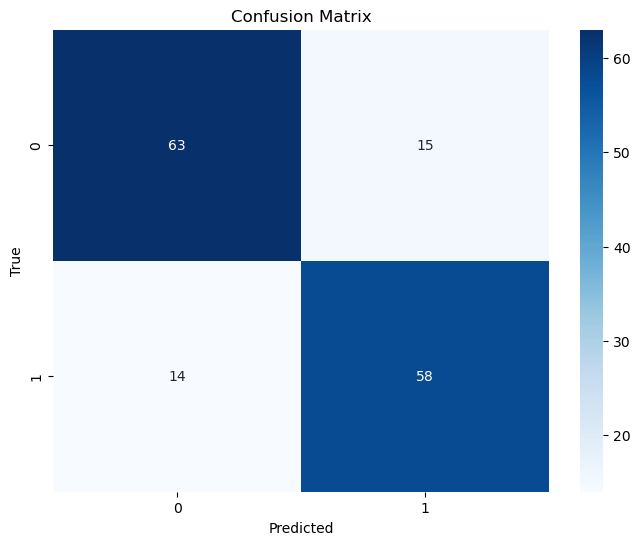

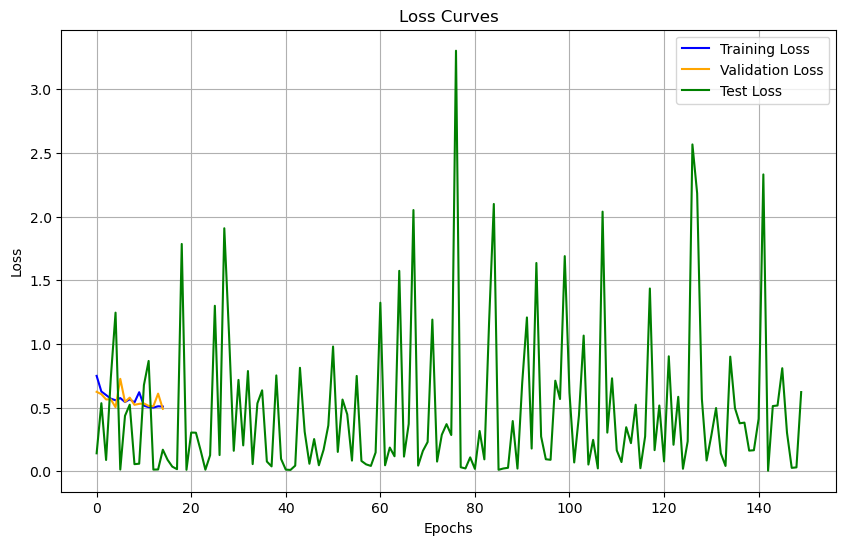

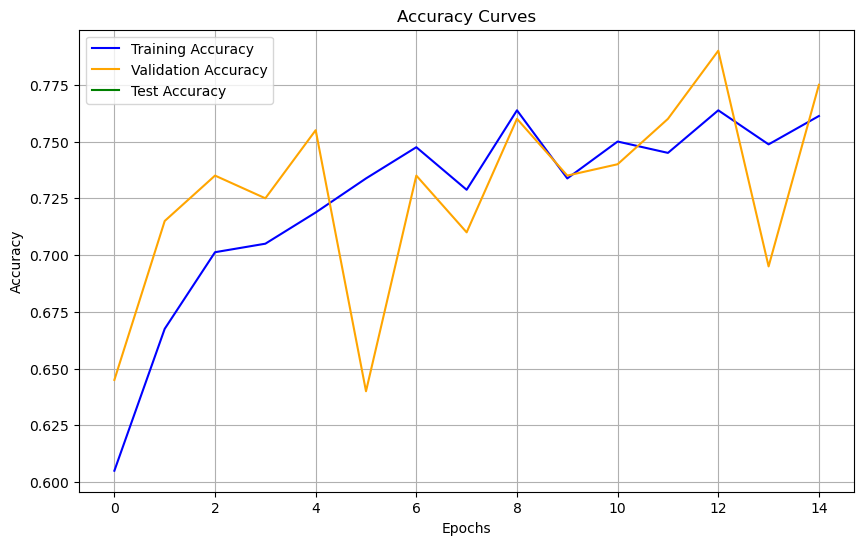

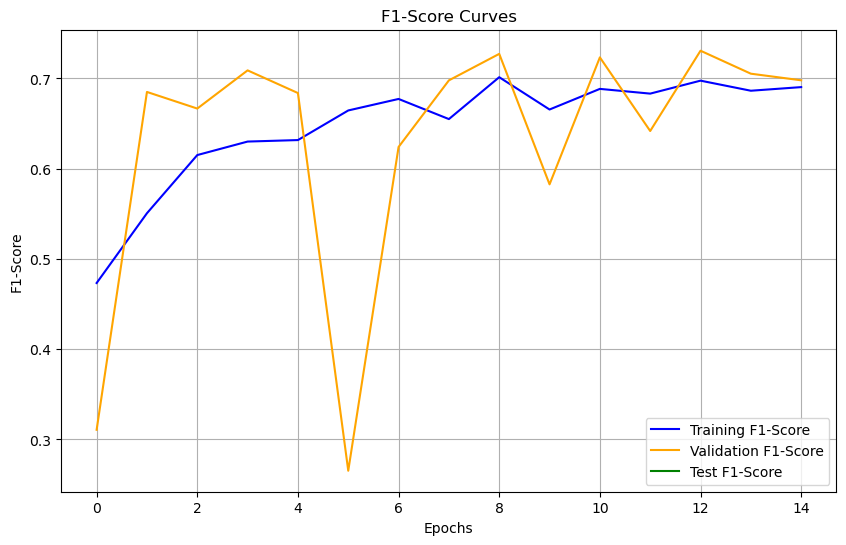

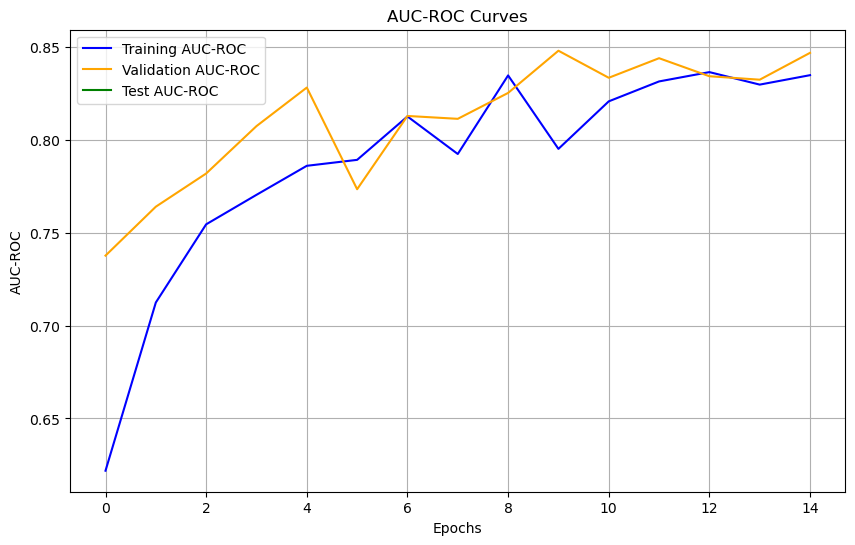

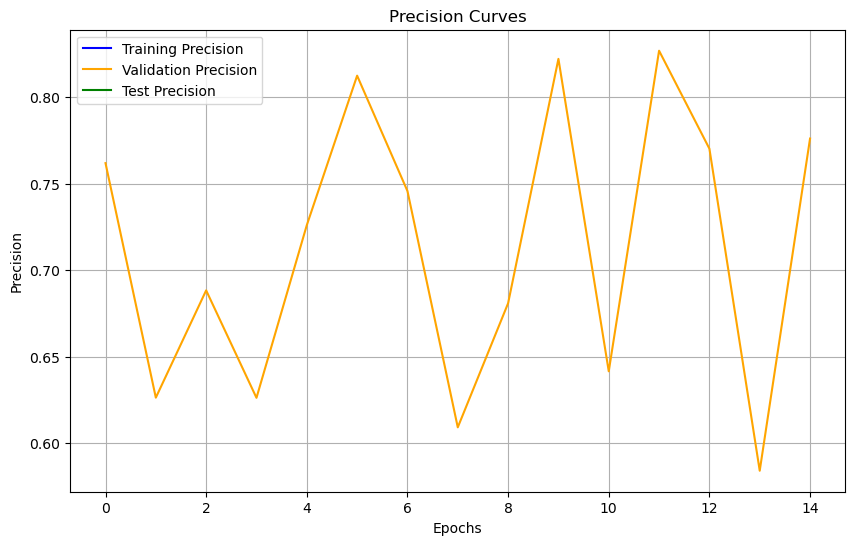

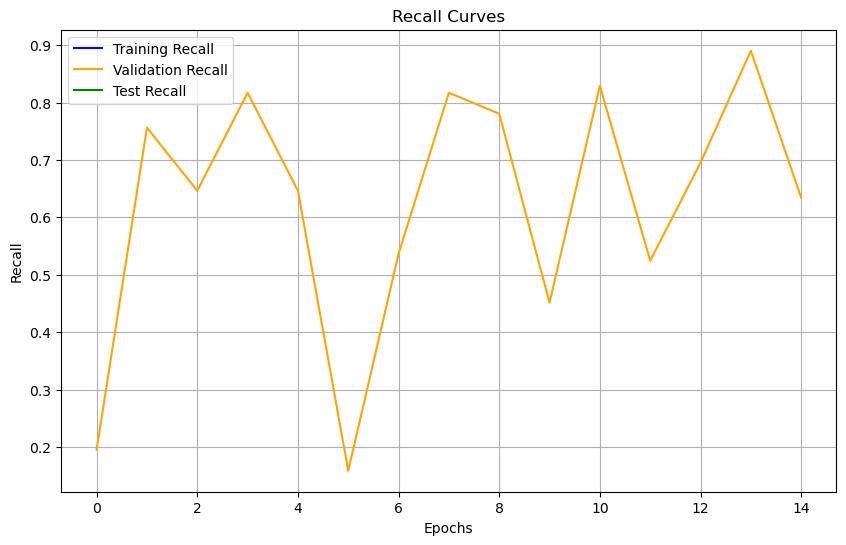

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▆▇▇▆█▇▇▇█▇█
train_auc,▁▄▅▆▆▆▇▇█▇▇████
train_f1,▁▃▅▆▆▇▇▇█▇█▇███
train_loss,█▅▄▃▃▃▂▃▂▄▁▁▁▁▁
val_accuracy,▁▄▅▅▆▁▅▄▇▅▆▇█▄▇


In [ ]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "input_feature_dim": 512,  # Características de ResNet50
    "feature_dim": 128,        # Dimensión final después de reducción
    "pooling_type": "attention",
    "num_epochs": 50,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimentoTFG
run_experiment(config_1)

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7341, Acc: 0.5938, AUC: 0.5919, F1: 0.4425
Val   - Loss: 0.6425, Acc: 0.6450, AUC: 0.7234, F1: 0.6468
Final model saved to ./models/rsna/model_mean.pth
Epoch 2/50
Train - Loss: 0.6378, Acc: 0.6438, AUC: 0.6804, F1: 0.5274
Val   - Loss: 0.6272, Acc: 0.6100, AUC: 0.7591, F1: 0.0930
Final model saved to ./models/rsna/model_mean.pth
Epoch 3/50
Train - Loss: 0.5915, Acc: 0.6837, AUC: 0.7423, F1: 0.5804
Val   - Loss: 0.5545, Acc: 0.7150, AUC: 0.7760, F1: 0.6174
Final model saved to ./models/rsna/model_mean.pth
Epoch 4/50
Train - Loss: 0.5738, Acc: 0.7113, AUC: 0.7653, F1: 0.6328
Val   - Loss: 0.5877, Acc: 0.6750, AUC: 0.7987, F1: 0.4248
Final model saved to ./models/rsna/model_mean.pth
Epoch 5/50
Train - Loss: 0.5394, A

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2592
Accuracy: 0.8533, AUC: 0.9208
Precision: 0.8289, Recall: 0.8750, F1-Score: 0.8514
Confusion Matrix:
[[65 13]
 [ 9 63]]


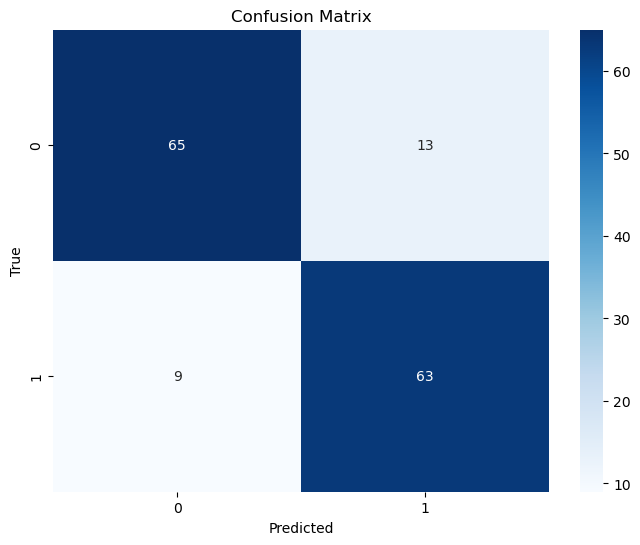

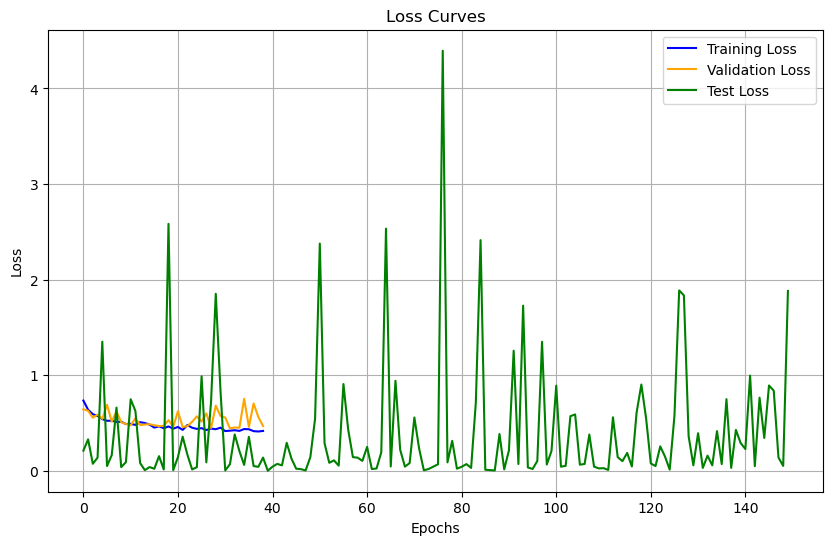

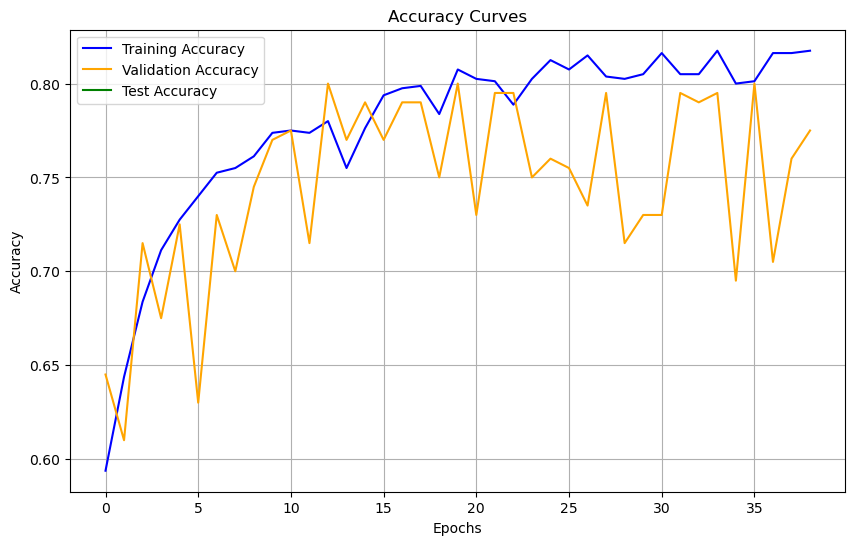

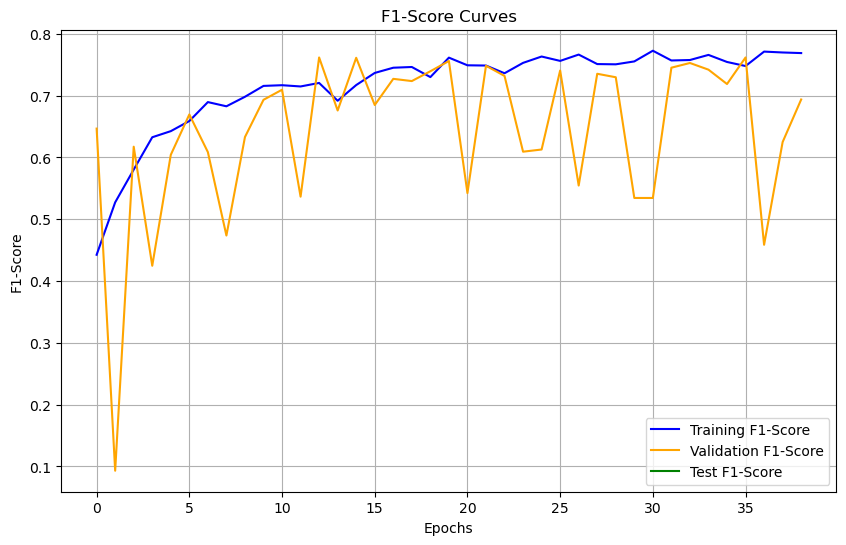

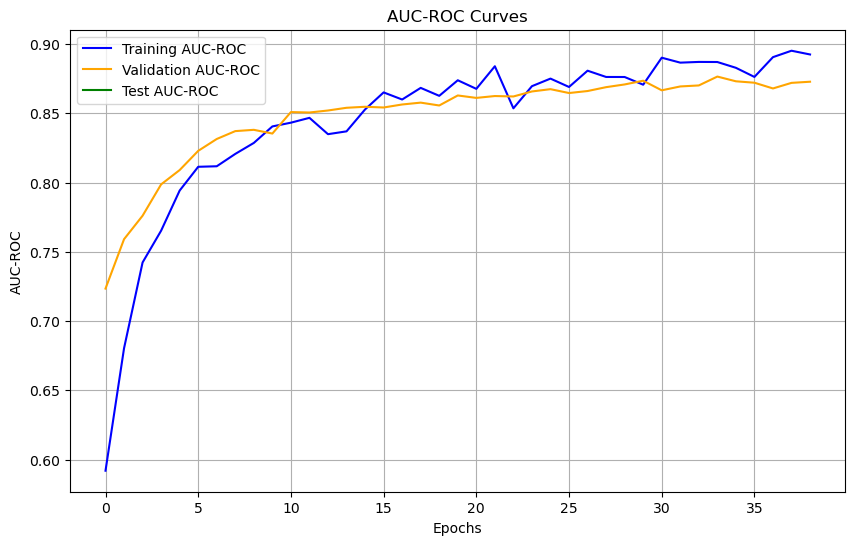

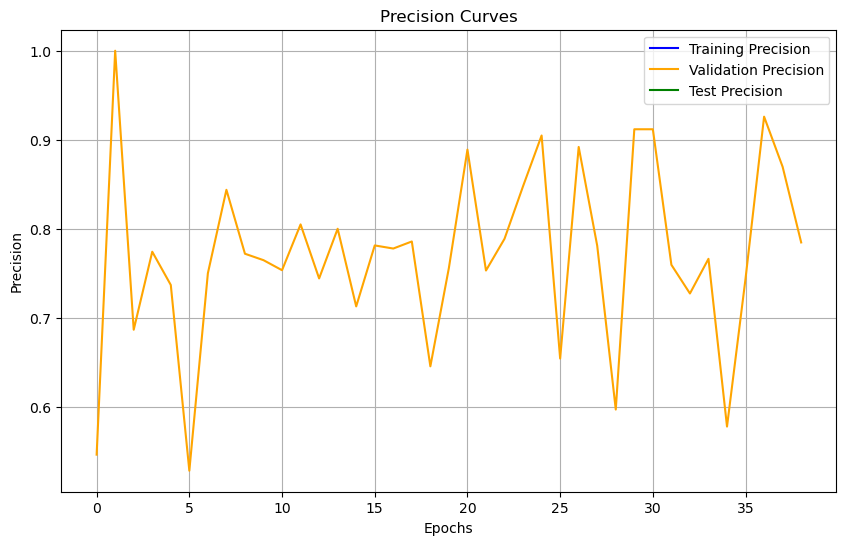

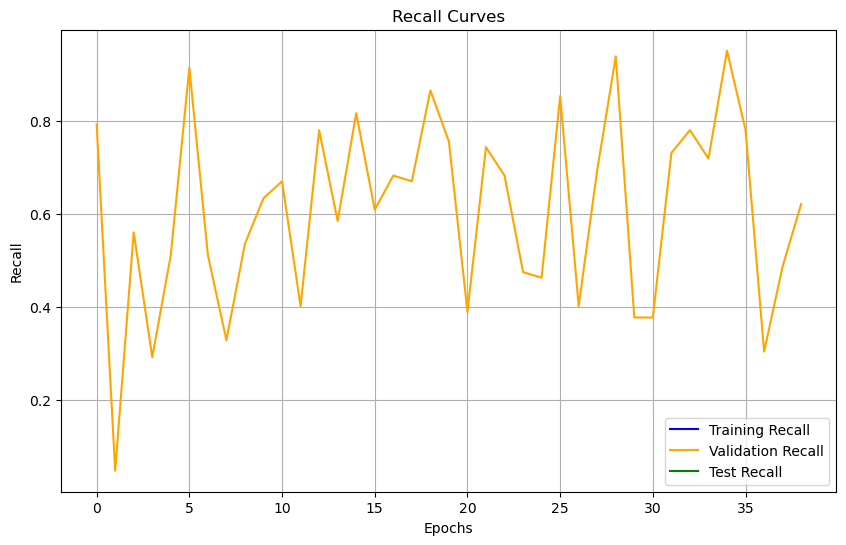

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇▆▇▇▇▇▇██▇▇███████████▇▇███
train_auc,▁▃▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇▇█▇███▇█████████
train_f1,▁▃▄▅▅▆▆▆▆▇▇▇▇▆▇▇▇▇▇█▇▇▇████████████▇███
train_loss,█▆▅▅▄▃▃▃▃▃▃▂▃▃▃▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▁▁▁▁▂▂▁▁▁
val_accuracy,▂▁▅▃▅▂▅▄▆▇▇▅█▇█▇██▆█▅██▆▇▆▆█▅▅▅███▄█▄▇▇


In [10]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "input_feature_dim": 512,  # Características de ResNet50
    "feature_dim": 128,        # Dimensión final después de reducción
    "pooling_type": "mean",
    "num_epochs": 50,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.7970, Acc: 0.6312, AUC: 0.6229, F1: 0.4723
Val   - Loss: 0.6906, Acc: 0.6950, AUC: 0.7087, F1: 0.6065
Final model saved to ./models/rsna/model_max.pth
Epoch 2/50
Train - Loss: 0.6926, Acc: 0.6937, AUC: 0.7406, F1: 0.5783
Val   - Loss: 0.7331, Acc: 0.6250, AUC: 0.7563, F1: 0.6445
Final model saved to ./models/rsna/model_max.pth
Epoch 3/50
Train - Loss: 0.7744, Acc: 0.7325, AUC: 0.7787, F1: 0.6537
Val   - Loss: 0.6358, Acc: 0.6050, AUC: 0.7966, F1: 0.6520
Final model saved to ./models/rsna/model_max.pth
Epoch 4/50
Train - Loss: 0.5854, Acc: 0.7525, AUC: 0.8196, F1: 0.6827
Val   - Loss: 0.5616, Acc: 0.7100, AUC: 0.8161, F1: 0.6979
Final model saved to ./models/rsna/model_max.pth
Epoch 5/50
Train - Loss: 0.4879, Acc: 

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2711
Accuracy: 0.8267, AUC: 0.8900
Precision: 0.7738, Recall: 0.9028, F1-Score: 0.8333
Confusion Matrix:
[[59 19]
 [ 7 65]]


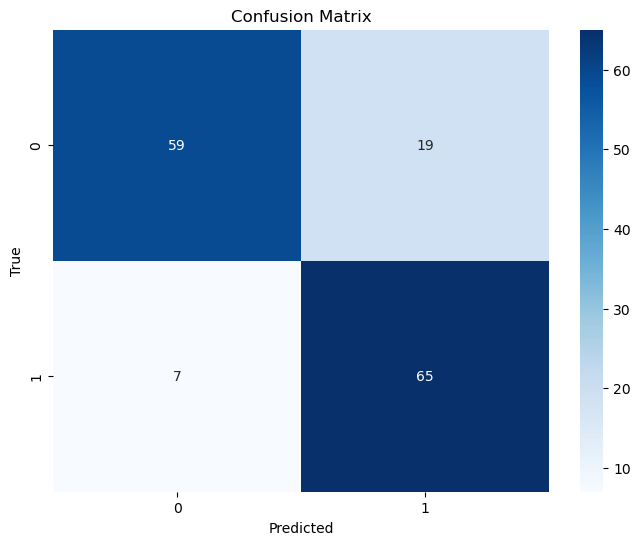

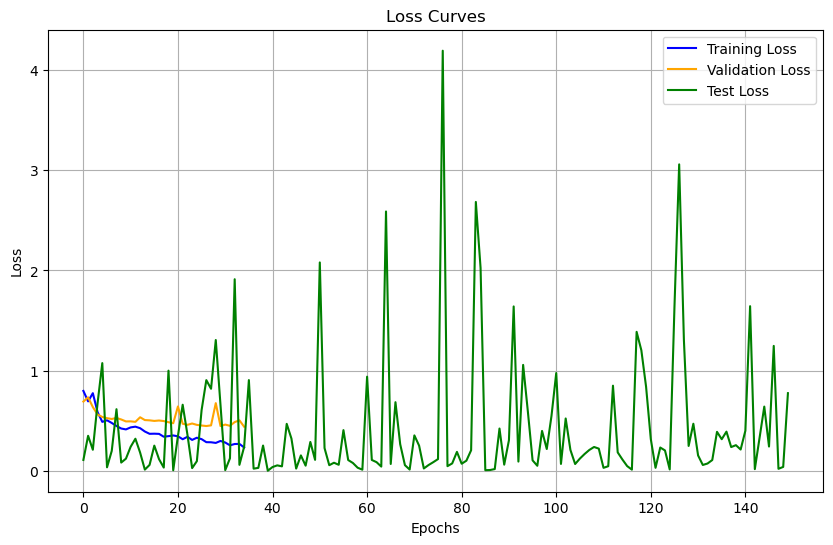

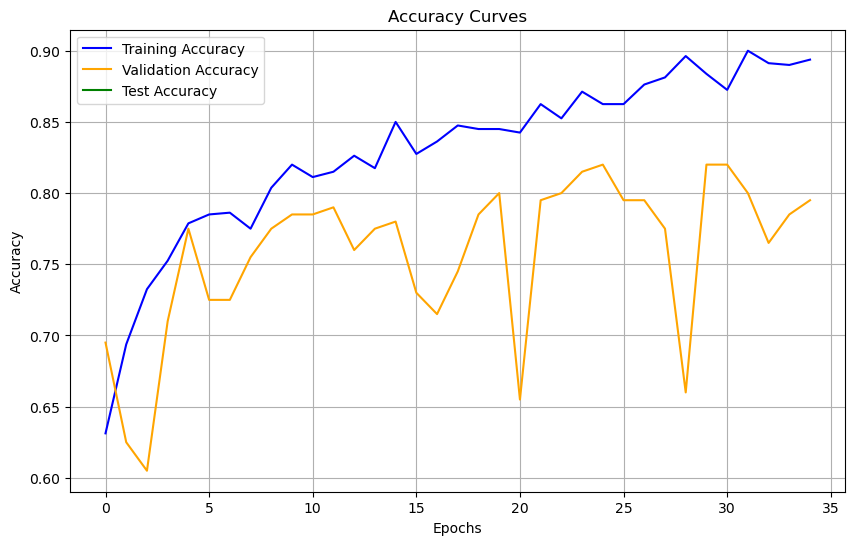

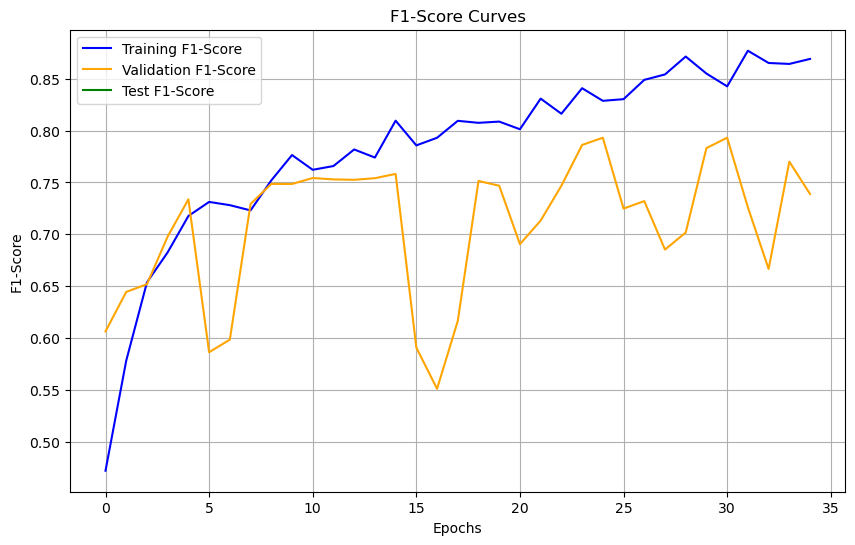

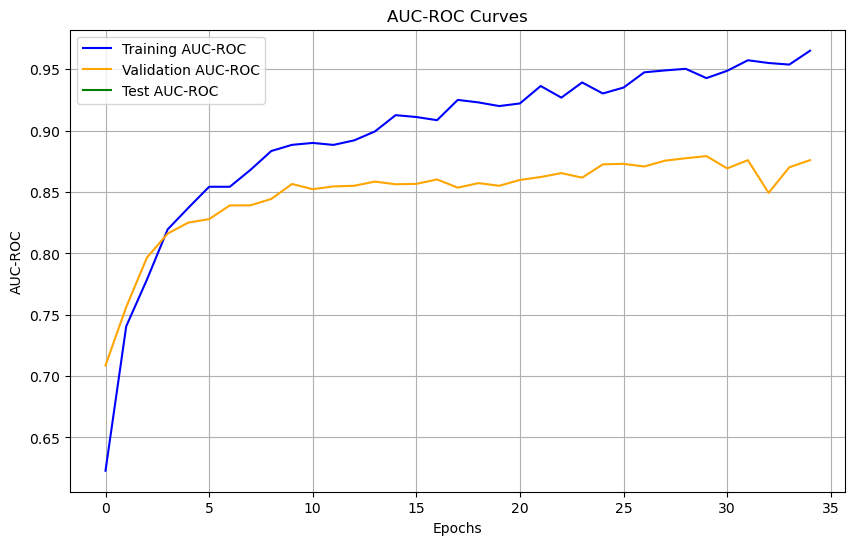

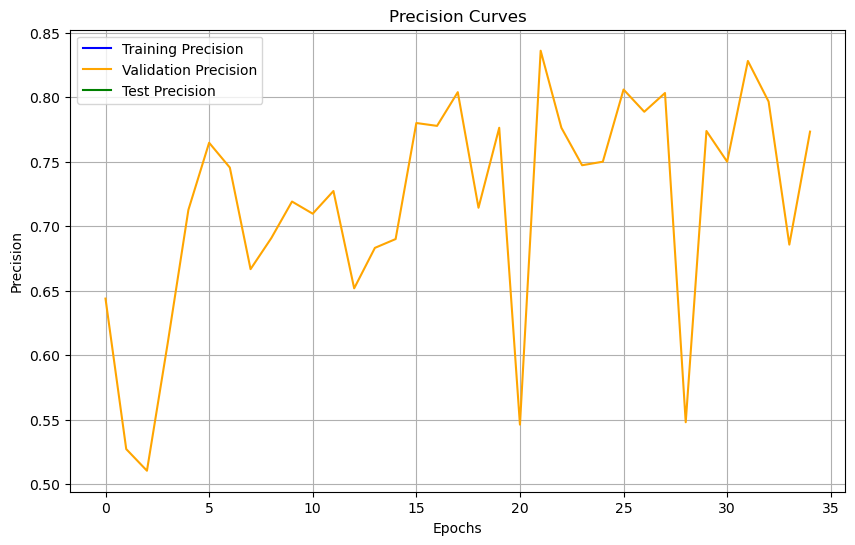

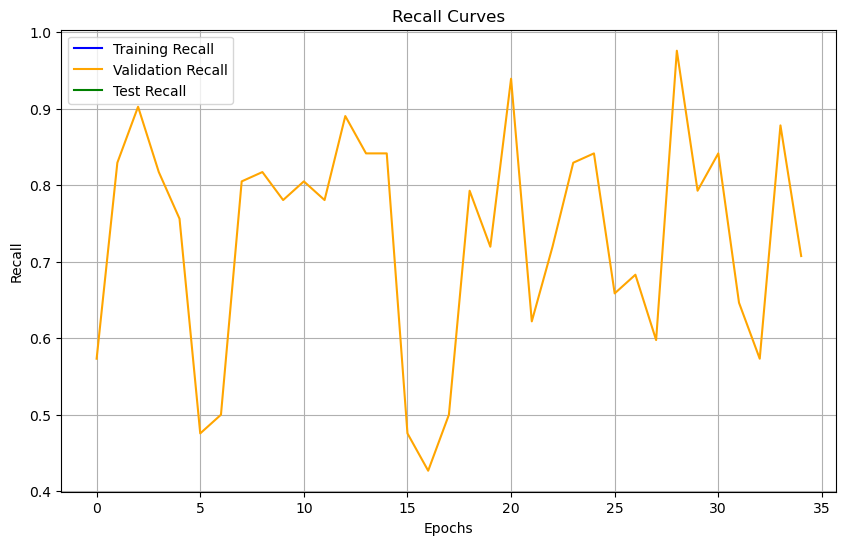

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▄▅▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇███▇████
train_auc,▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████
train_f1,▁▃▄▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇████▇████
train_loss,█▇█▅▄▄▄▄▃▃▃▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_accuracy,▄▂▁▄▇▅▅▆▇▇▇▇▆▇▇▅▅▆▇▇▃▇▇██▇▇▇▃██▇▆▇▇


In [11]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "input_feature_dim": 512,  # Características de ResNet50
    "feature_dim": 128,        # Dimensión final después de reducción
    "pooling_type": "max",
    "num_epochs": 50,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

**ENTRENAMIENTOS Y RESULTADOS**
**ResNet-18**

*Learning Rate 1e-3*

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6884, Acc: 0.6188, AUC: 0.6228, F1: 0.4942
Val   - Loss: 0.6892, Acc: 0.6250, AUC: 0.7036, F1: 0.2424
Final model saved to ./models/rsna/model_attention.pth
Epoch 2/50
Train - Loss: 0.5968, Acc: 0.6925, AUC: 0.7403, F1: 0.5954
Val   - Loss: 0.5497, Acc: 0.7200, AUC: 0.7803, F1: 0.6216
Final model saved to ./models/rsna/model_attention.pth
Epoch 3/50
Train - Loss: 0.5667, Acc: 0.7312, AUC: 0.7820, F1: 0.6493
Val   - Loss: 0.6769, Acc: 0.6600, AUC: 0.7926, F1: 0.6792
Final model saved to ./models/rsna/model_attention.pth
Epoch 4/50
Train - Loss: 0.5864, Acc: 0.7212, AUC: 0.7777, F1: 0.6499
Val   - Loss: 0.6921, Acc: 0.6350, AUC: 0.7751, F1: 0.6726
Epoch 5/50
Train - Loss: 0.5494, Acc: 0.7238, AUC: 0.7907, F1: 0.6395

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.3669
Accuracy: 0.8000, AUC: 0.8759
Precision: 0.7442, Recall: 0.8889, F1-Score: 0.8101
Confusion Matrix:
[[56 22]
 [ 8 64]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


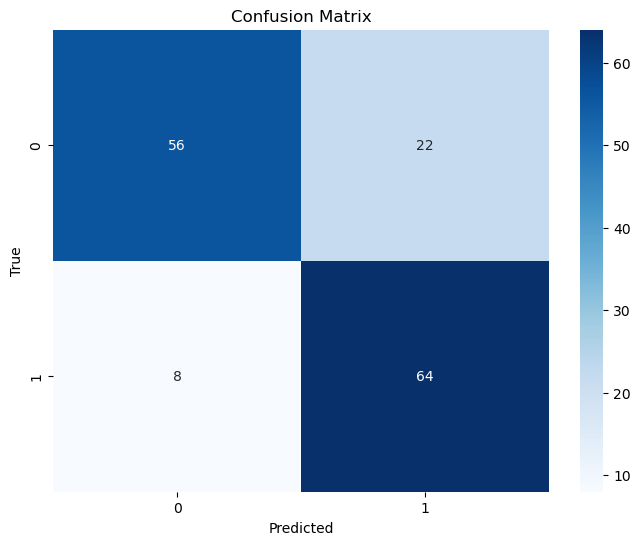

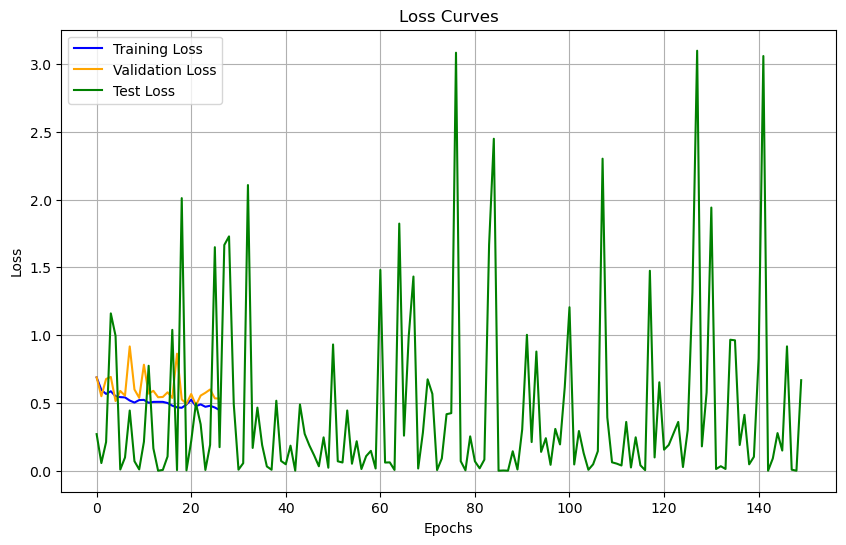

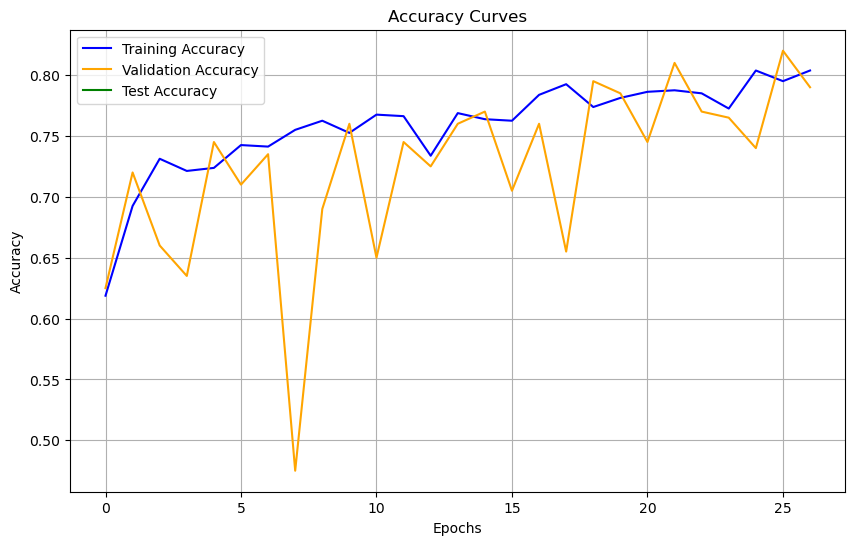

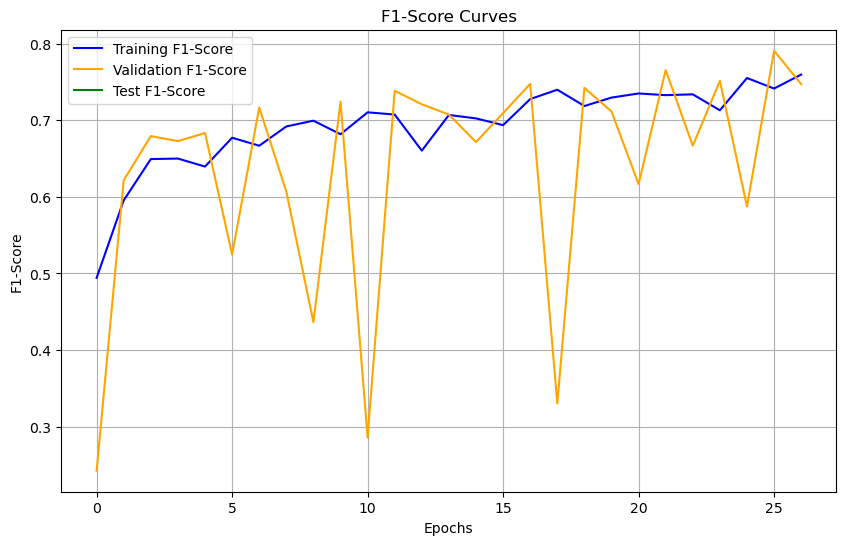

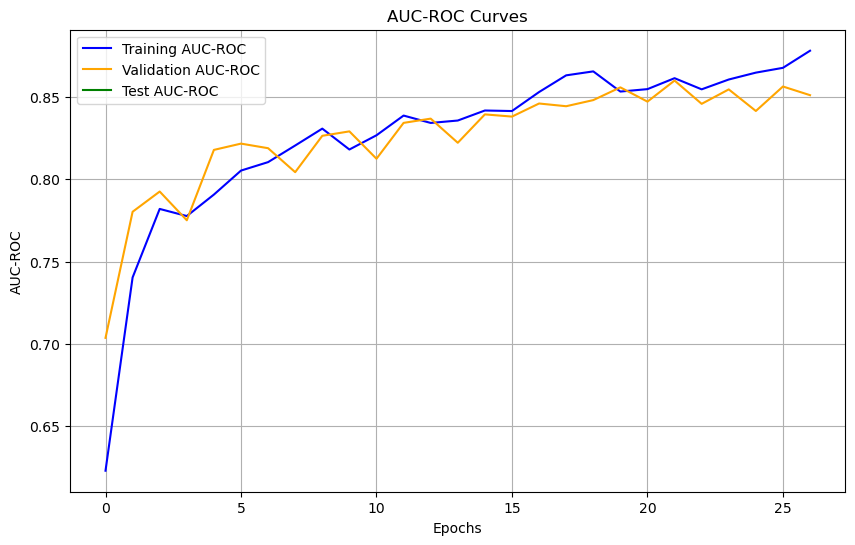

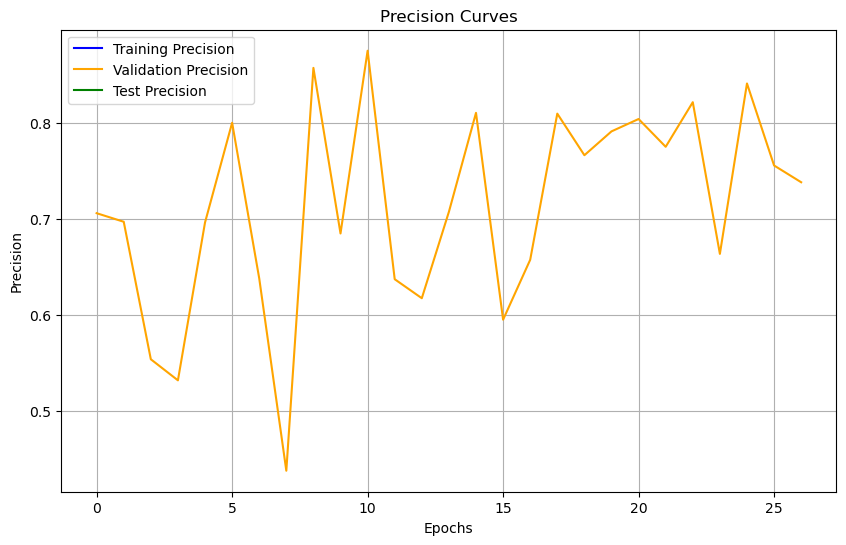

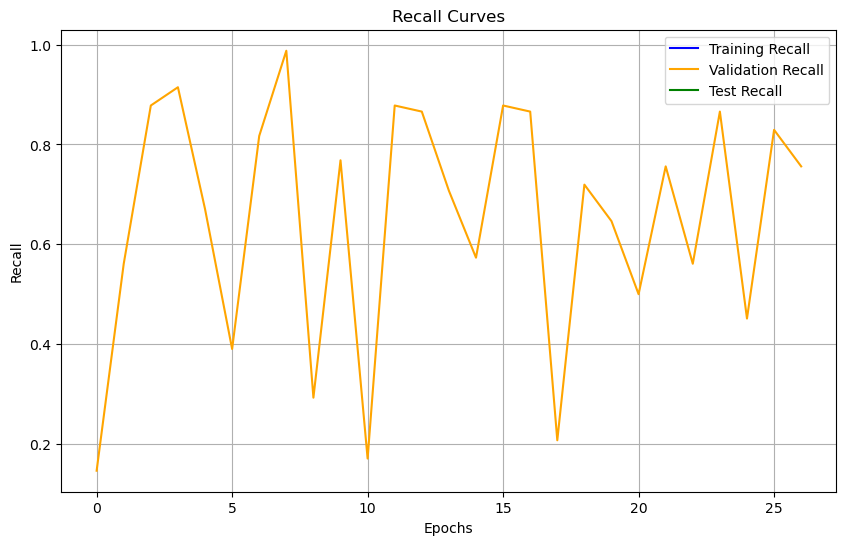

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▅▅▆▆▆▆▆▇▇▅▇▆▆▇█▇▇▇▇▇▇███
train_auc,▁▄▅▅▆▆▆▆▇▆▇▇▇▇▇▇▇██▇▇█▇████
train_f1,▁▄▅▅▅▆▆▆▆▆▇▇▅▇▆▆▇▇▇▇▇▇▇▇███
train_loss,█▅▄▅▄▄▄▃▃▃▃▃▃▃▃▃▂▂▁▂▃▂▂▂▂▂▁
val_accuracy,▄▆▅▄▆▆▆▁▅▇▅▆▆▇▇▆▇▅▇▇▆█▇▇▆█▇


In [10]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "input_feature_dim": 512,  # Características de ResNet50
    "feature_dim": 128,        # Dimensión final después de reducción
    "pooling_type": "attention",
    "num_epochs": 50,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

*Learning Rate 1e-4*

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 0.6502, Acc: 0.6038, AUC: 0.6289, F1: 0.4030
Val   - Loss: 0.6636, Acc: 0.5950, AUC: 0.7171, F1: 0.0241
Final model saved to ./models/rsna/model_attention.pth
Epoch 2/50
Train - Loss: 0.5872, Acc: 0.6925, AUC: 0.7455, F1: 0.5773
Val   - Loss: 0.5804, Acc: 0.7150, AUC: 0.7477, F1: 0.6225
Final model saved to ./models/rsna/model_attention.pth
Epoch 3/50
Train - Loss: 0.5531, Acc: 0.7262, AUC: 0.7861, F1: 0.6344
Val   - Loss: 0.5786, Acc: 0.6850, AUC: 0.7728, F1: 0.6400
Final model saved to ./models/rsna/model_attention.pth
Epoch 4/50
Train - Loss: 0.5196, Acc: 0.7450, AUC: 0.8095, F1: 0.6699
Val   - Loss: 0.5397, Acc: 0.7450, AUC: 0.7915, F1: 0.6577
Final model saved to ./models/rsna/model_attention.pth
Epoch 5/50
Tra

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.2679
Accuracy: 0.8000, AUC: 0.8738
Precision: 0.7917, Recall: 0.7917, F1-Score: 0.7917
Confusion Matrix:
[[63 15]
 [15 57]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


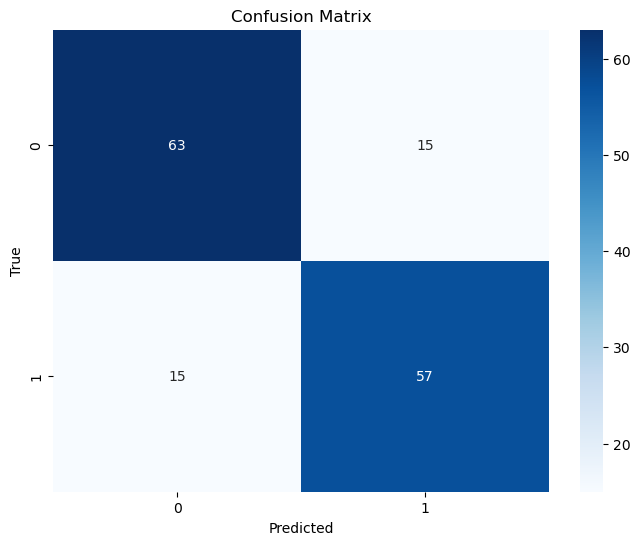

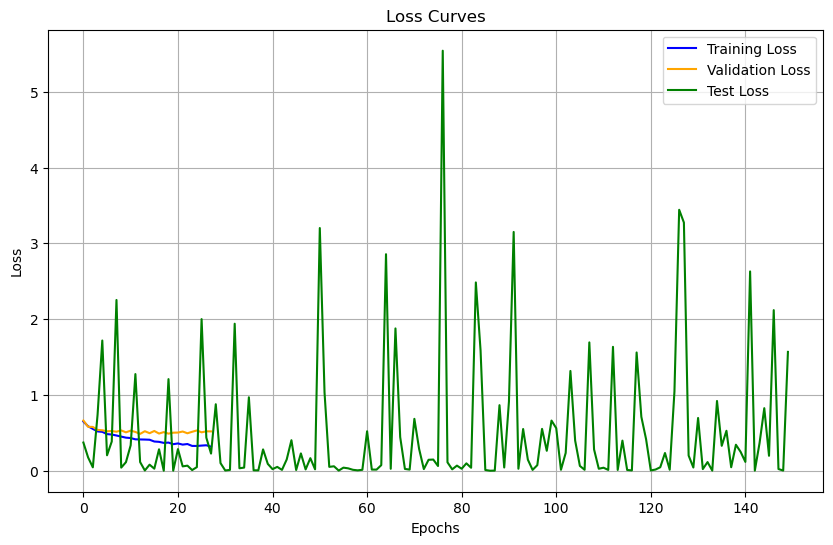

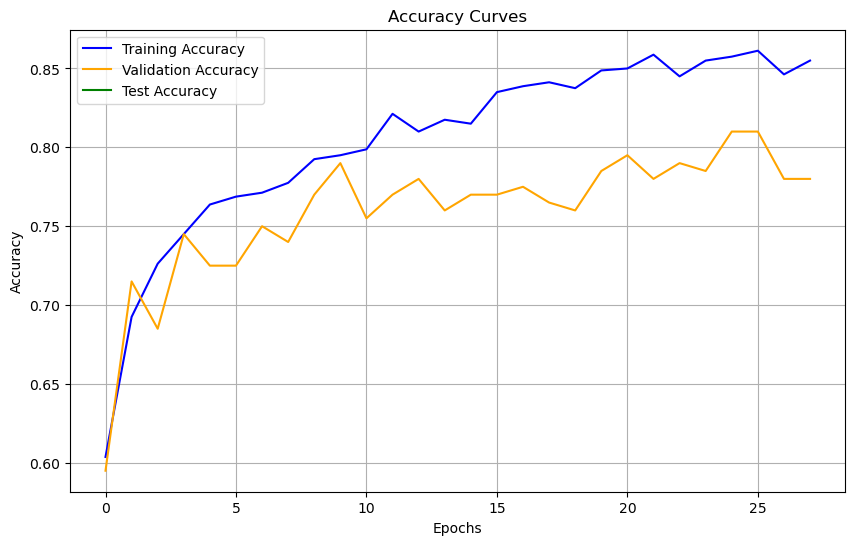

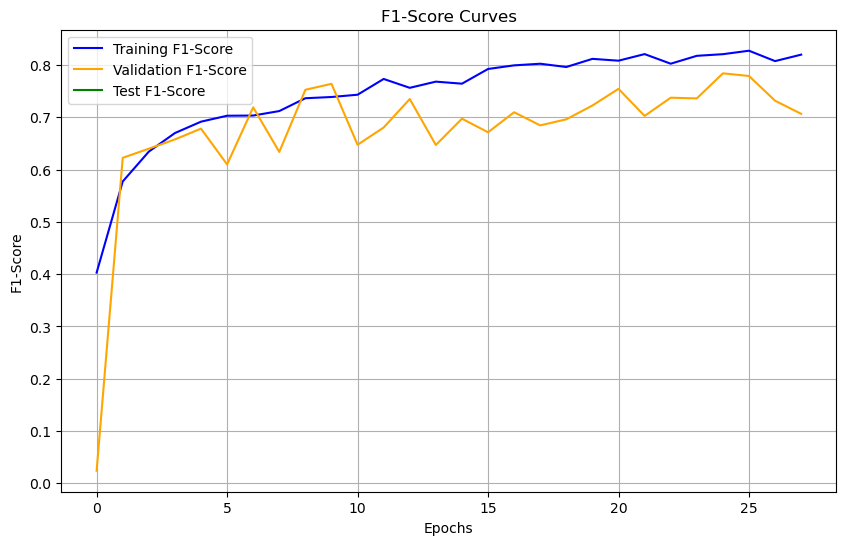

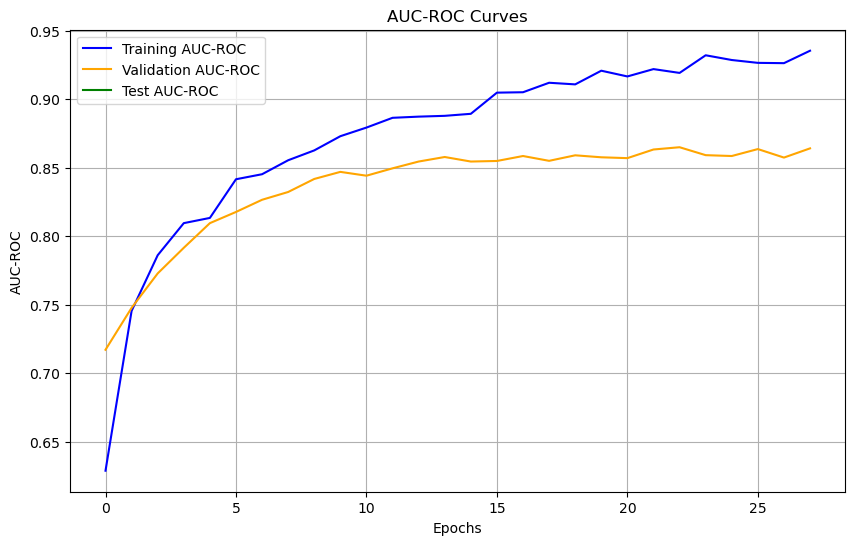

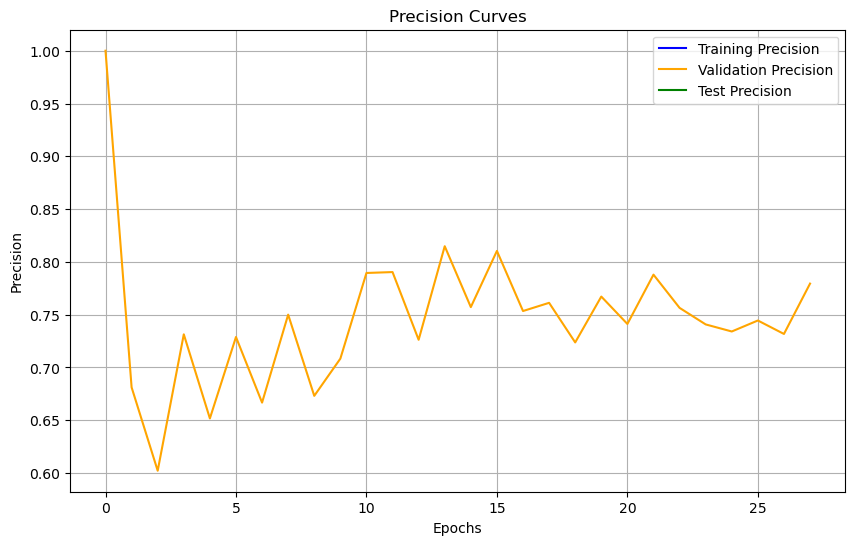

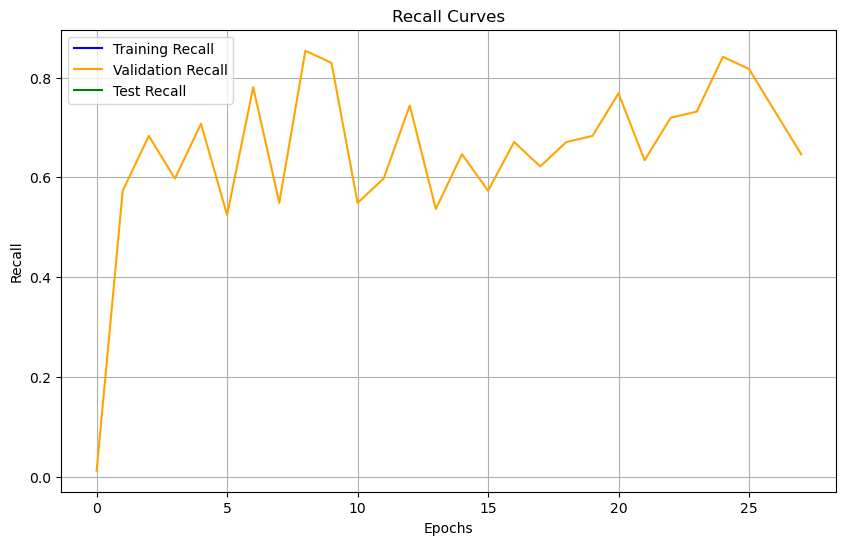

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█████████
train_auc,▁▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████
train_f1,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇██▇█████████
train_loss,█▇▆▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▅▄▆▅▅▆▆▇▇▆▇▇▆▇▇▇▇▆▇█▇▇▇██▇▇


In [11]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "input_feature_dim": 512,  # Características de ResNet50
    "feature_dim": 128,        # Dimensión final después de reducción
    "pooling_type": "attention",
    "num_epochs": 50,
    "learning_rate": 1e-4,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

*Learning Rate 1e-2*

rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 1000 already processed bags
[RSNADataset] Number of bags found: 1000
rsna
[RSNADataset] Scanning files...
[RSNADataset] Found 150 already processed bags
[RSNADataset] Number of bags found: 150
Epoch 1/50
Train - Loss: 19.1920, Acc: 0.5200, AUC: 0.5164, F1: 0.4164
Val   - Loss: 7.0876, Acc: 0.5900, AUC: 0.6199, F1: 0.5543
Final model saved to ./models/rsna/model_attention.pth


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 2/50
Train - Loss: 43.5664, Acc: 0.5238, AUC: 0.5197, F1: 0.4219
Val   - Loss: 23.5130, Acc: 0.5900, AUC: 0.6465, F1: 0.0000
Final model saved to ./models/rsna/model_attention.pth


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 3/50
Train - Loss: 26.0619, Acc: 0.5800, AUC: 0.5835, F1: 0.4909
Val   - Loss: 25.5788, Acc: 0.5900, AUC: 0.6843, F1: 0.0000
Final model saved to ./models/rsna/model_attention.pth
Epoch 4/50
Train - Loss: 21.7803, Acc: 0.5913, AUC: 0.5769, F1: 0.5038
Val   - Loss: 12.0112, Acc: 0.5750, AUC: 0.6666, F1: 0.3511
Epoch 5/50
Train - Loss: 21.5347, Acc: 0.5675, AUC: 0.5659, F1: 0.4758
Val   - Loss: 36.1433, Acc: 0.4100, AUC: 0.5030, F1: 0.5816
Epoch 6/50
Train - Loss: 33.6021, Acc: 0.5650, AUC: 0.5515, F1: 0.4711
Val   - Loss: 23.8366, Acc: 0.4400, AUC: 0.5506, F1: 0.5912
Epoch 7/50
Train - Loss: 44.1754, Acc: 0.5463, AUC: 0.5261, F1: 0.4492
Val   - Loss: 63.4490, Acc: 0.4100, AUC: 0.5085, F1: 0.5816


/home/javitrucas/miniconda3/envs/tfg/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 8/50
Train - Loss: 54.6060, Acc: 0.5825, AUC: 0.5744, F1: 0.4893
Val   - Loss: 73.4114, Acc: 0.5900, AUC: 0.5000, F1: 0.0000
Early stopping triggered.
Model loaded successfully from ./models/rsna/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.0000
Accuracy: 0.5200, AUC: 0.5011
Precision: 0.5000, Recall: 0.0139, F1-Score: 0.0270
Confusion Matrix:
[[77  1]
 [71  1]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


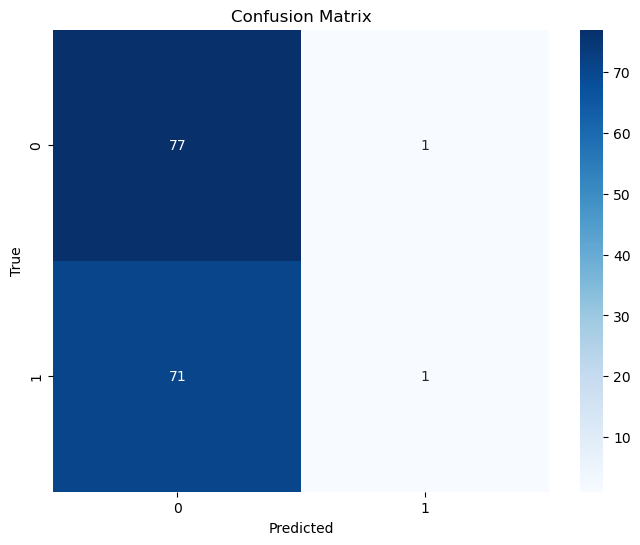

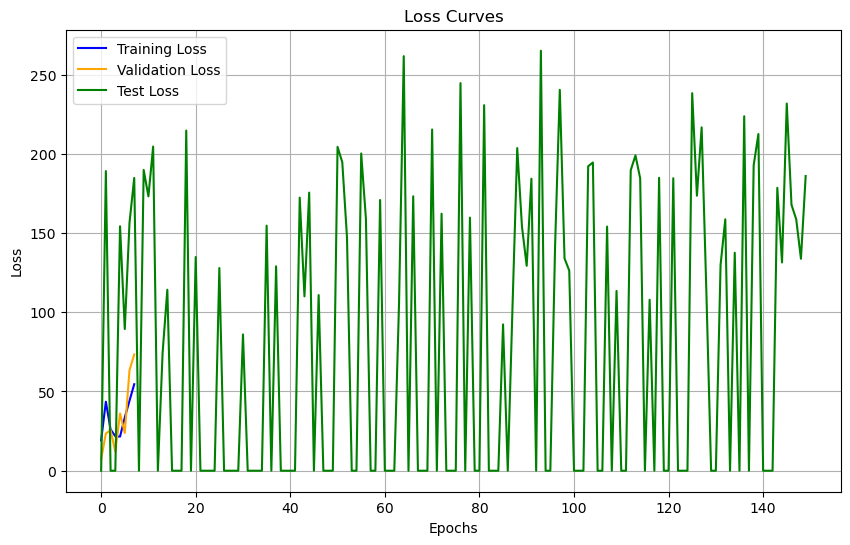

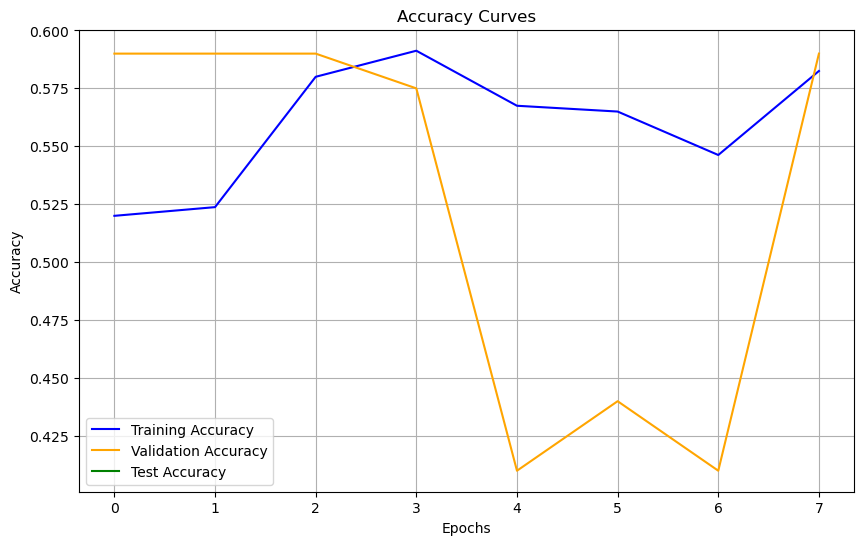

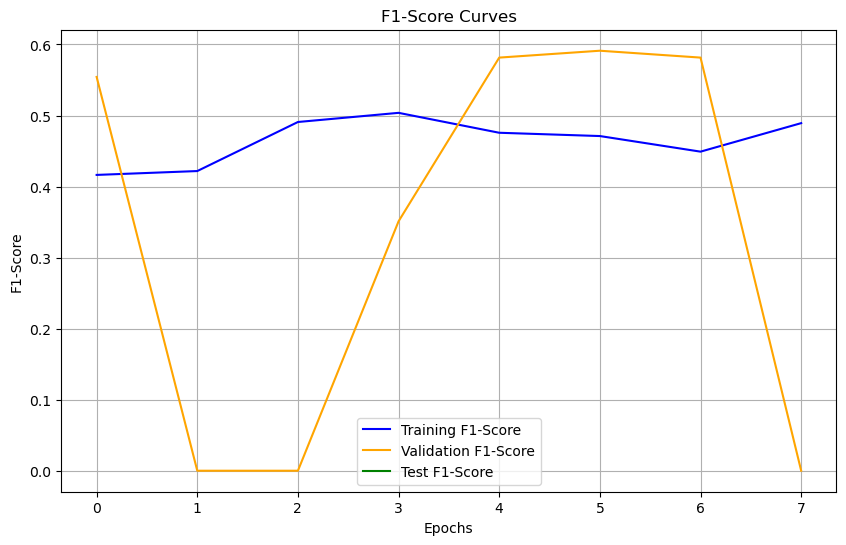

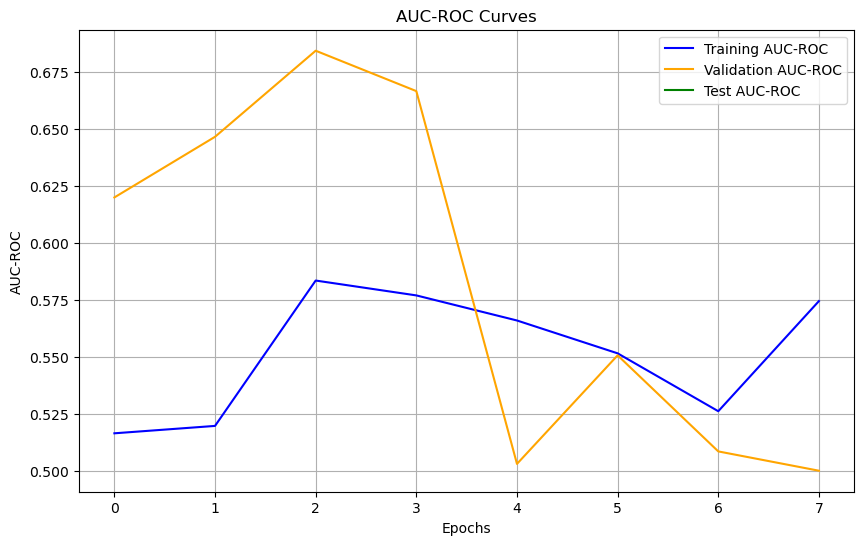

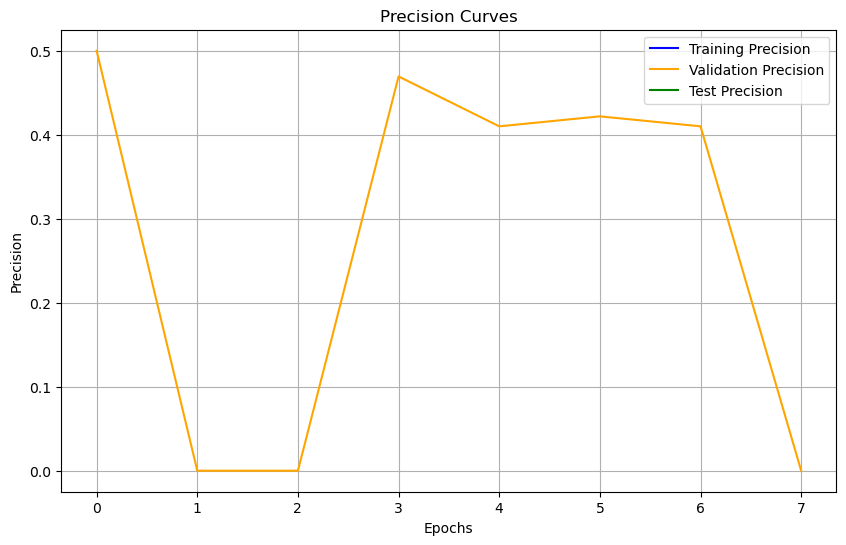

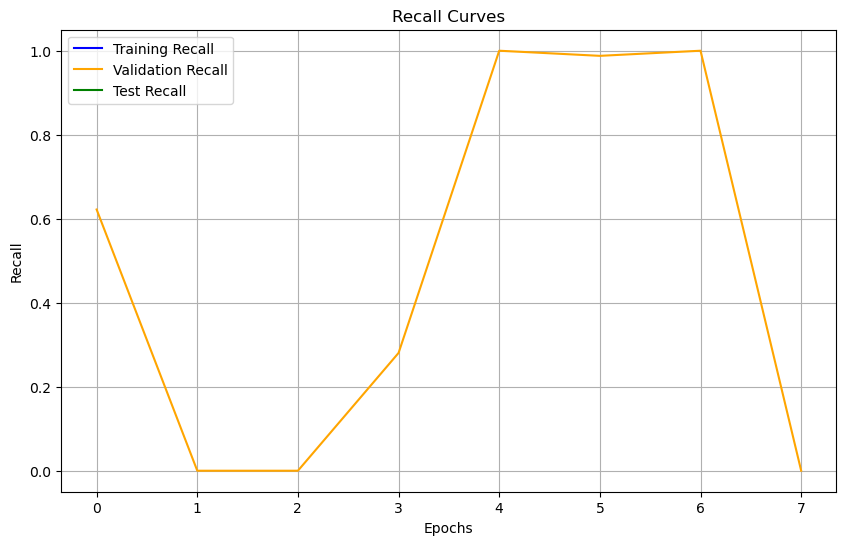

epoch,▁▂▃▄▅▆▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▁▇█▆▅▄▇
train_auc,▁▁█▇▆▅▂▇
train_f1,▁▁▇█▆▅▄▇
train_loss,▁▆▂▂▁▄▆█
val_accuracy,███▇▁▂▁█


In [12]:
# Convertir config_1 en un objeto usando Box
config_1 = Box({
    "dataset_name": "rsna-features_resnet18",
    "input_feature_dim": 512,  # Características de ResNet50
    "feature_dim": 128,        # Dimensión final después de reducción
    "pooling_type": "attention",
    "num_epochs": 50,
    "learning_rate": 1e-2,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_1)

**ENTRENAMIENTOS Y RESULTADOS**
**Con diferentes modelos atención PANDA**

PANDA-attention

panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:09<00:00, 127.13it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:15<00:00, 117.52it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2548, Acc: 0.9115, AUC: 0.9622, F1: 0.9393
Val   - Loss: 0.2994, Acc: 0.8883, AUC: 0.9855, F1: 0.9282
Final model saved to ./models/panda/model_attention.pth
Epoch 2/15
Train - Loss: 0.2337, Acc: 0.9271, AUC: 0.9737, F1: 0.9500
Val   - Loss: 0.2698, Acc: 0.9297, AUC: 0.9799, F1: 0.9501
Epoch 3/15
Train - Loss: 0.2537, Acc: 0.9298, AUC: 0.9753, F1: 0.9518
Val   - Loss: 0.3333, Acc: 0.9099, AUC: 0.9845, F1: 0.9410
Epoch 4/15
Train - Loss: 0.2650, Acc: 0.9318, AUC: 0.9754, F1: 0.9532
Val   - Loss: 0.2319, Acc: 0.9410, AUC: 0.9847, F1: 0.9598
Epoch 5/15
Train - Loss: 0.2872, Acc: 0.9285, AUC: 0.9731, F1: 0.9509
Val   - Loss: 0.2528, Acc: 0.9308, AUC: 0.9800, F1: 0.9530
Epoch 6/15
Train - Loss: 0.2703, Acc: 0.9308, AUC: 0.9760, F1: 0.9525
Val   - Loss: 0.2220, Acc: 0.9422, AUC: 0.9837, F1: 0.9598
Early stopping triggered.
Model loaded successfully from ./models/panda/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/attention/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.9417
Accuracy: 0.9415, AUC: 0.9862
Precision: 0.9893, Recall: 0.9291, F1-Score: 0.9583
Confusion Matrix:
[[ 484   13]
 [  92 1205]]
Attention heatmap 0 saved at output/attention/attention_heatmap_0.png
Attention heatmap 1 saved at output/attention/attention_heatmap_1.png
Attention heatmap 2 saved at output/attention/attention_heatmap_2.png
Attention heatmap 3 saved at output/attention/attention_heatmap_3.png
Attention heatmap 4 saved at output/attention/attention_heatmap_4.png


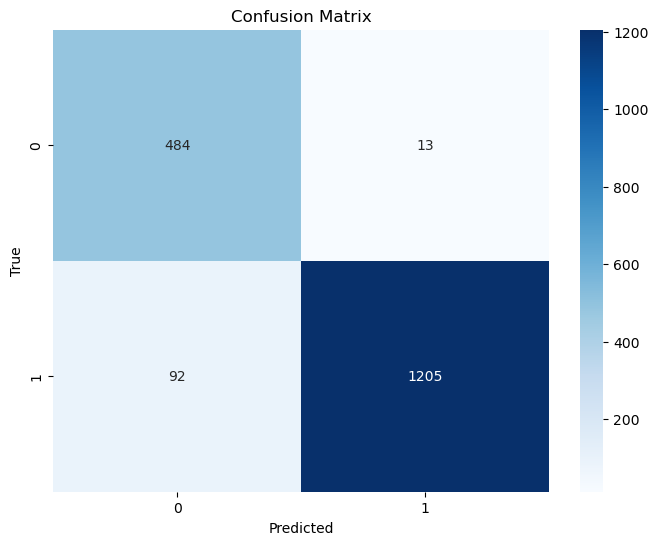

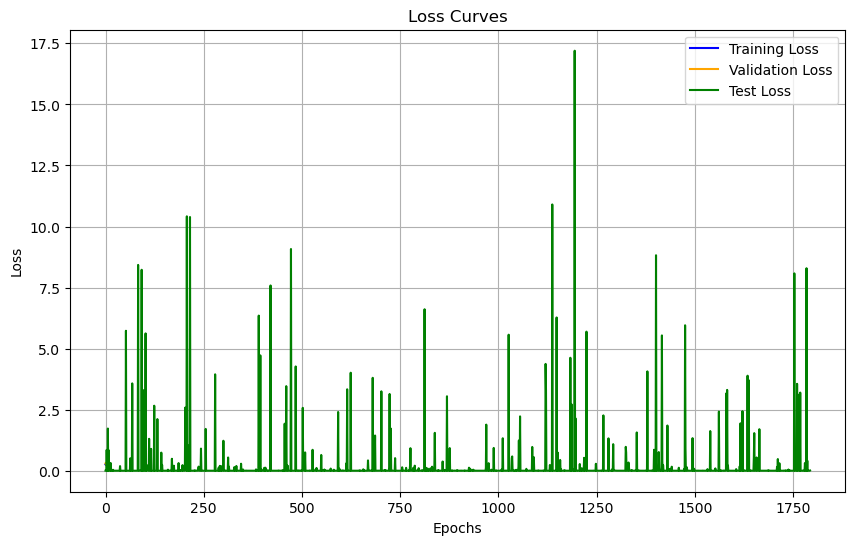

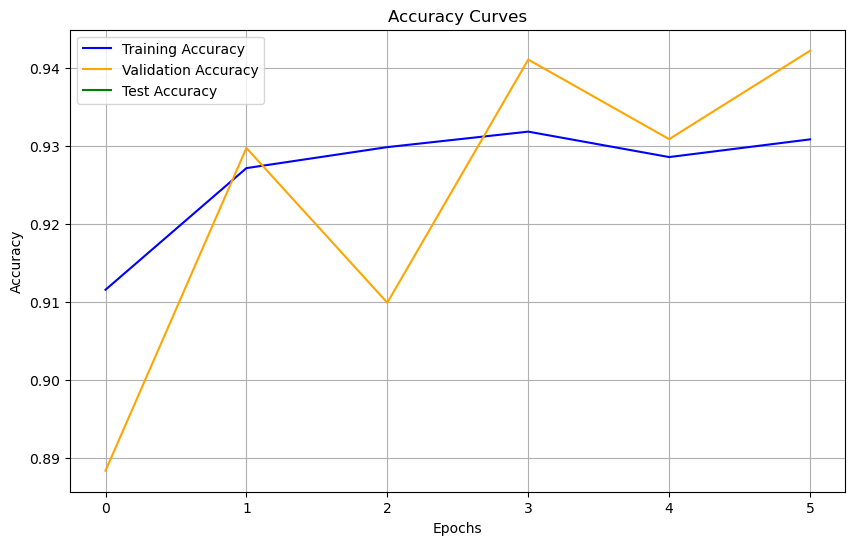

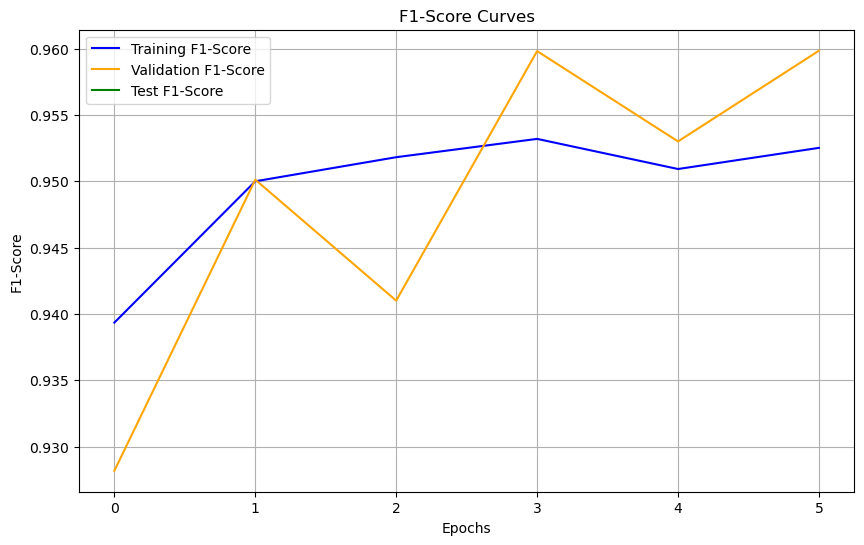

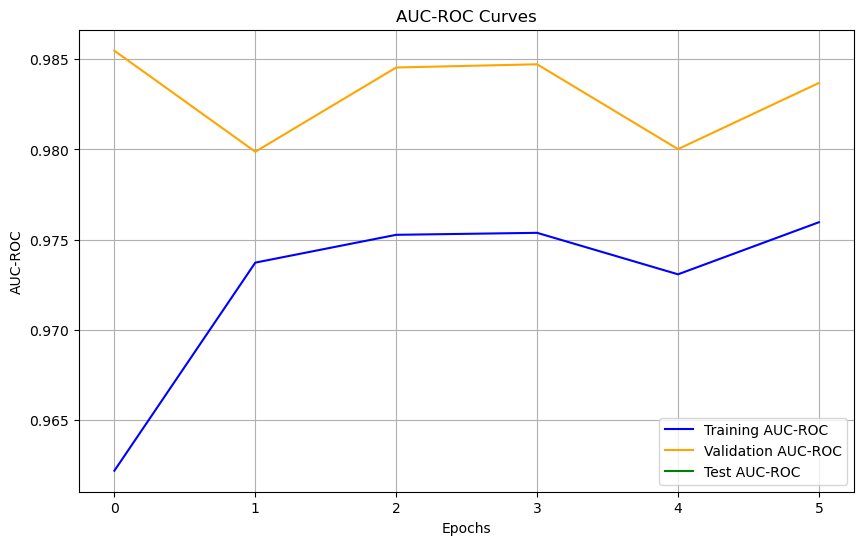

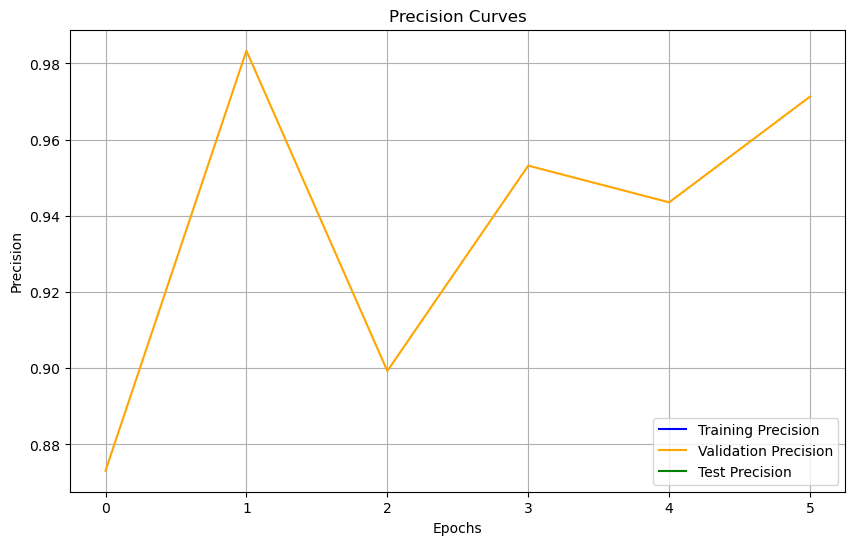

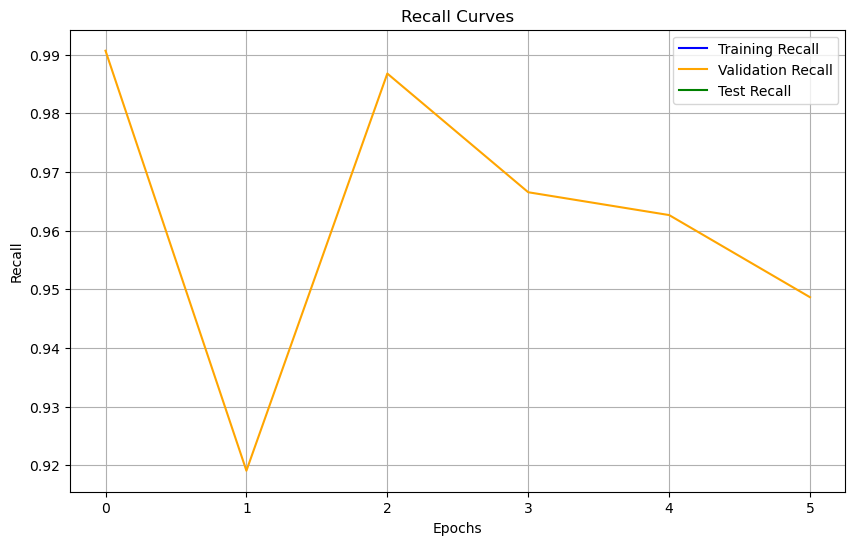

epoch,▁▂▄▅▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▆▇█▇█
train_auc,▁▇██▇█
train_f1,▁▆▇█▇█
train_loss,▄▁▄▅█▆
val_accuracy,▁▆▄█▇█


In [13]:
config_panda = Box({
    "dataset_name": "panda-patches_512_preset-features_UNI",
    "input_feature_dim": 1024,  # Dimensionalidad de las características pre-extraídas
    "feature_dim": 128,         # Dimensionalidad final después de reducción
    "pooling_type": "attention",  # Tipo de pooling (puede ser 'attention', 'mean', 'max')
    "num_epochs": 15,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_panda)

PANDA-mean

panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [00:55<00:00, 160.06it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:12<00:00, 147.61it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.3590, Acc: 0.8351, AUC: 0.8991, F1: 0.8871
Val   - Loss: 0.5016, Acc: 0.7591, AUC: 0.9428, F1: 0.8576
Final model saved to ./models/panda/model_mean.pth
Epoch 2/15
Train - Loss: 0.3083, Acc: 0.8562, AUC: 0.9276, F1: 0.9013
Val   - Loss: 0.2701, Acc: 0.8787, AUC: 0.9452, F1: 0.9138
Final model saved to ./models/panda/model_mean.pth
Epoch 3/15
Train - Loss: 0.2907, Acc: 0.8694, AUC: 0.9365, F1: 0.9102
Val   - Loss: 0.2501, Acc: 0.8798, AUC: 0.9498, F1: 0.9168
Final model saved to ./models/panda/model_mean.pth
Epoch 4/15
Train - Loss: 0.2847, Acc: 0.8711, AUC: 0.9402, F1: 0.9114
Val   - Loss: 0.3509, Acc: 0.8260, AUC: 0.9361, F1: 0.8663
Epoch 5/15
Train - Loss: 0.2773, Acc: 0.8782, AUC: 0.9440, F1: 0.9163
Val   - Loss: 0.2755, Acc: 0.8741, AUC: 0.9499, F1: 0.9096
Final model saved to ./models/panda/model_mean.pth
Epoch 6/15
Train - Loss: 0.2677, Acc: 0.8795, AUC: 0.9480, F1: 0.9170
Val   

/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/mean/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.9097
Accuracy: 0.8696, AUC: 0.9578
Precision: 0.9784, Recall: 0.8381, F1-Score: 0.9028
Confusion Matrix:
[[ 473   24]
 [ 210 1087]]


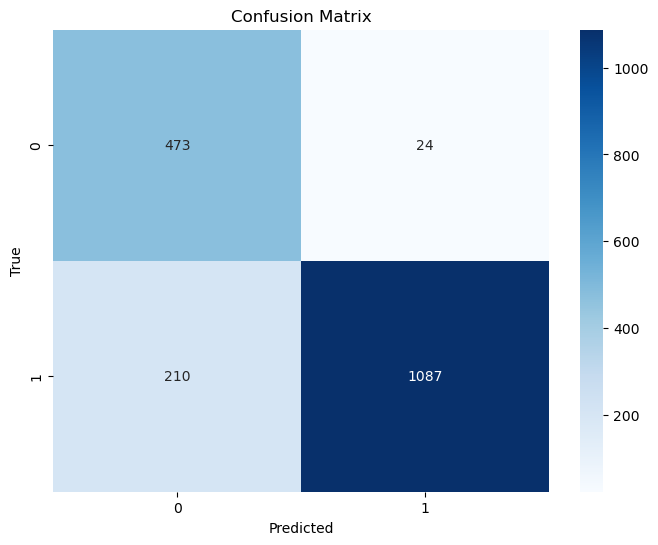

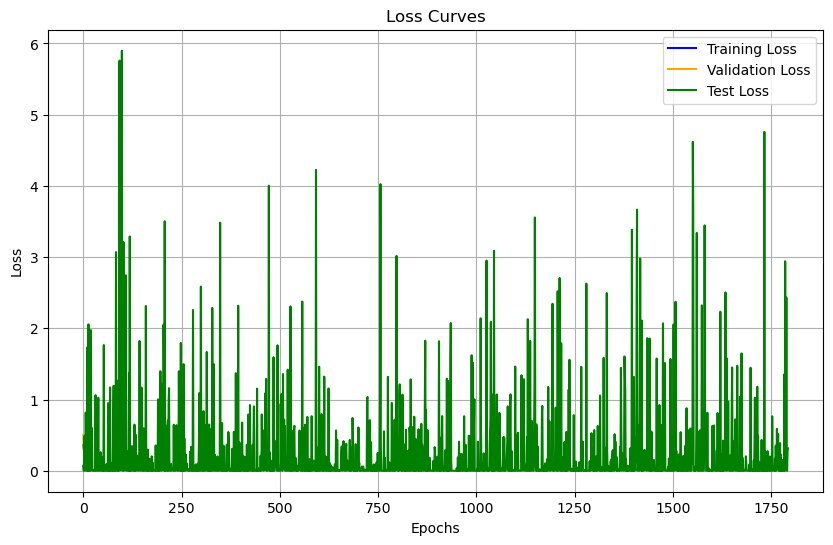

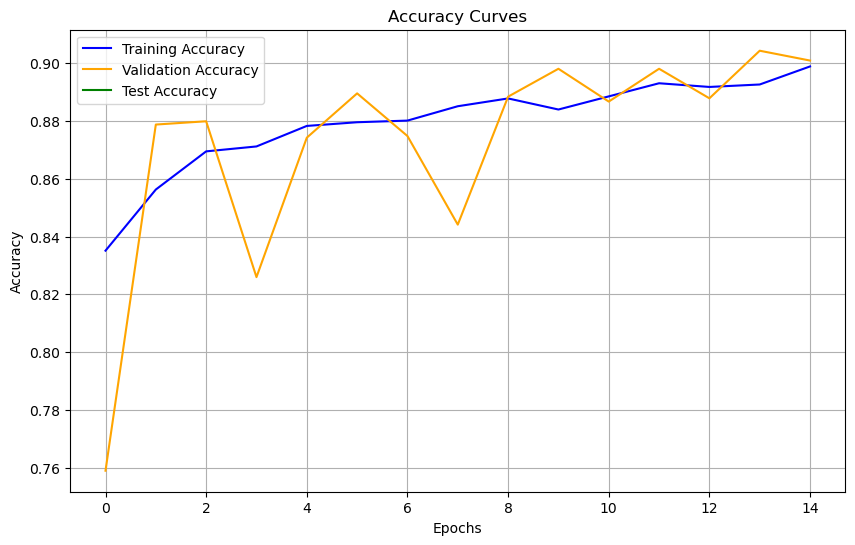

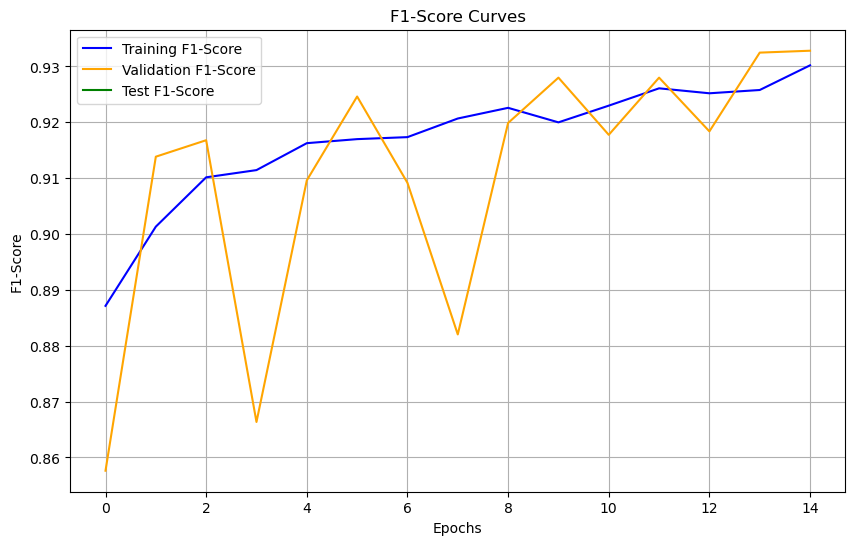

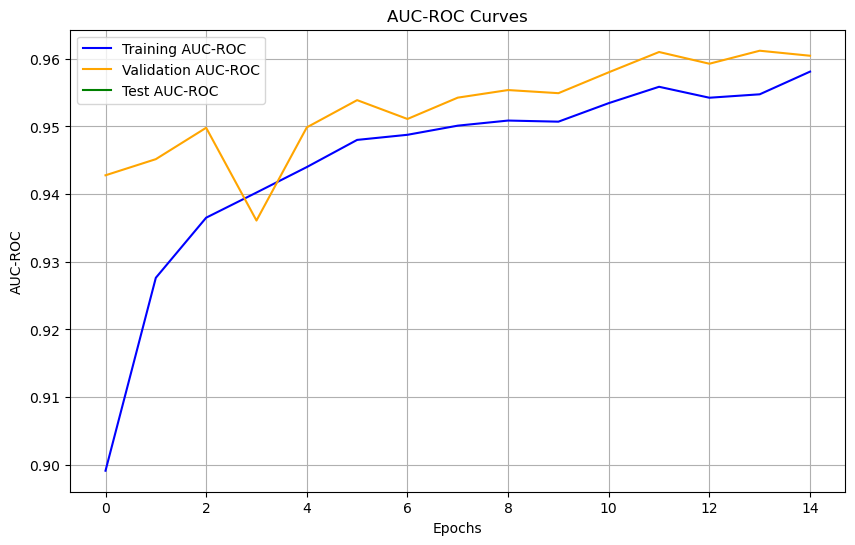

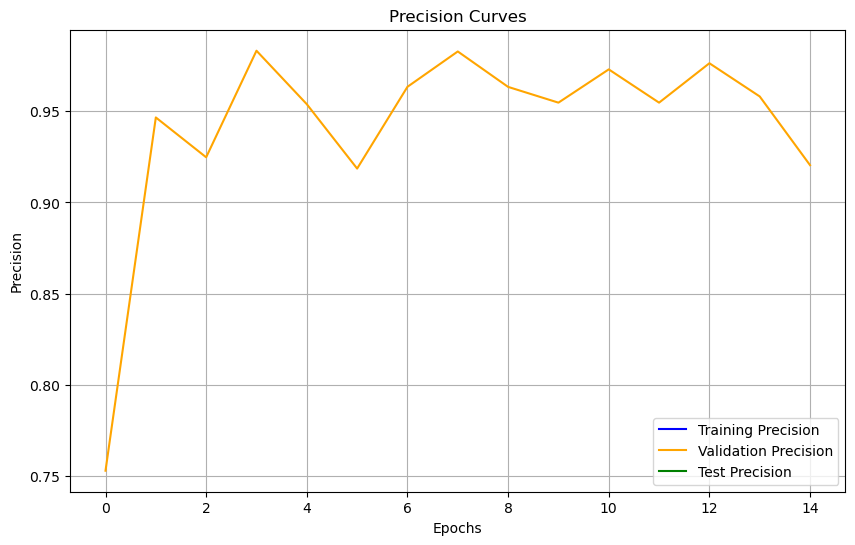

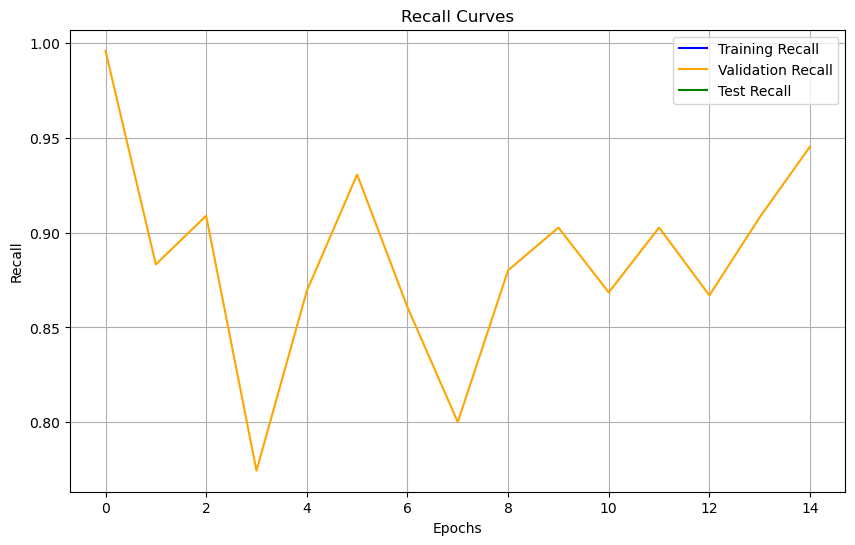

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▃▅▅▆▆▆▆▇▆▇▇▇▇█
train_auc,▁▄▅▆▆▇▇▇▇▇▇████
train_f1,▁▃▅▅▆▆▆▆▇▆▇▇▇▇█
train_loss,█▅▄▃▃▂▂▂▂▂▂▁▂▁▁
val_accuracy,▁▇▇▄▇▇▇▅▇█▇█▇██


In [14]:
config_panda = Box({
    "dataset_name": "panda-patches_512_preset-features_UNI",
    "input_feature_dim": 1024,  # Dimensionalidad de las características pre-extraídas
    "feature_dim": 128,         # Dimensionalidad final después de reducción
    "pooling_type": "mean",  # Tipo de pooling (puede ser 'attention', 'mean', 'max')
    "num_epochs": 15,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_panda)

PANDA-max

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: javitrucas (javitrucas-universidad-de-granada) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 8822/8822 [01:12<00:00, 121.54it/s]


[WSIDataset] Skipped 5 bags
[WSIDataset] Found 8817 already processed bags
panda
[WSIDataset] Scanning files...


[WSIDataset] Building data dict: 100%|██████████| 1794/1794 [00:16<00:00, 111.55it/s]


[WSIDataset] Skipped 0 bags
[WSIDataset] Found 1794 already processed bags
Epoch 1/15
Train - Loss: 0.2046, Acc: 0.9219, AUC: 0.9690, F1: 0.9458
Val   - Loss: 0.2049, Acc: 0.9206, AUC: 0.9823, F1: 0.9432
Final model saved to ./models/panda/model_max.pth
Epoch 2/15
Train - Loss: 0.1611, Acc: 0.9386, AUC: 0.9802, F1: 0.9574
Val   - Loss: 0.2327, Acc: 0.9320, AUC: 0.9730, F1: 0.9522
Epoch 3/15
Train - Loss: 0.1457, Acc: 0.9441, AUC: 0.9832, F1: 0.9613
Val   - Loss: 0.3003, Acc: 0.9410, AUC: 0.9733, F1: 0.9583
Epoch 4/15
Train - Loss: 0.1307, Acc: 0.9522, AUC: 0.9868, F1: 0.9669
Val   - Loss: 0.2313, Acc: 0.9427, AUC: 0.9761, F1: 0.9603
Epoch 5/15
Train - Loss: 0.1255, Acc: 0.9549, AUC: 0.9874, F1: 0.9687
Val   - Loss: 0.7719, Acc: 0.8141, AUC: 0.9563, F1: 0.8838
Epoch 6/15
Train - Loss: 0.1202, Acc: 0.9577, AUC: 0.9892, F1: 0.9707
Val   - Loss: 0.7137, Acc: 0.8158, AUC: 0.9415, F1: 0.8827
Early stopping triggered.
Model loaded successfully from ./models/panda/model.pth


/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + ["Negative", "Positive"])
/home/javitrucas/TFG/scripts/medical_scripts/medical_evaluation.py:65: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + ["Negative", "Positive"])


Confusion matrix saved at output/max/confusion_matrix.png

--- Evaluation Results ---
Optimal Threshold: 0.9991
Accuracy: 0.8891, AUC: 0.9437
Precision: 0.9791, Recall: 0.8651, F1-Score: 0.9185
Confusion Matrix:
[[ 473   24]
 [ 175 1122]]


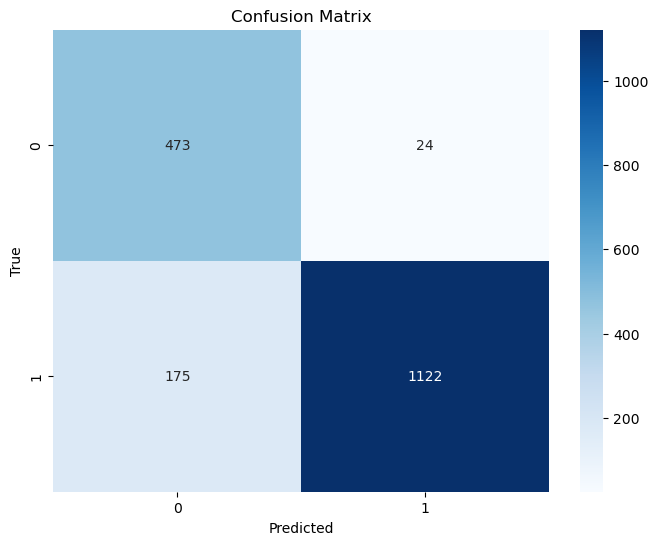

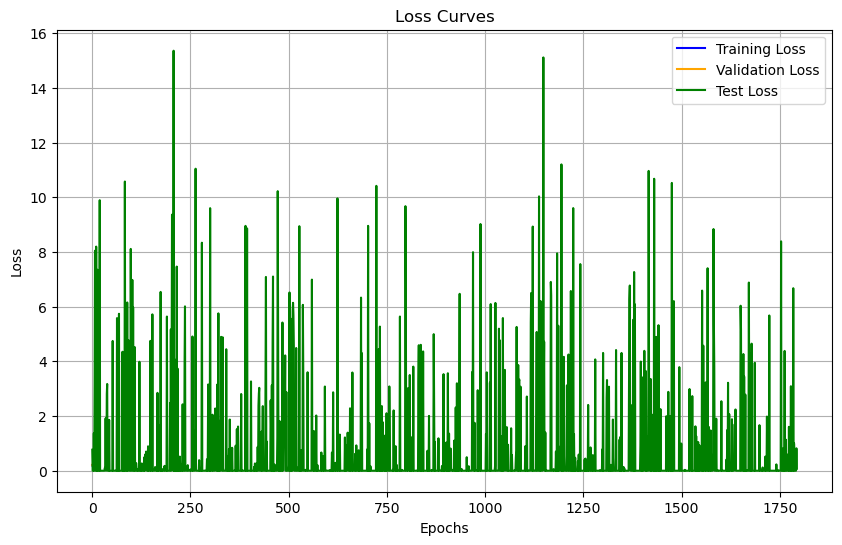

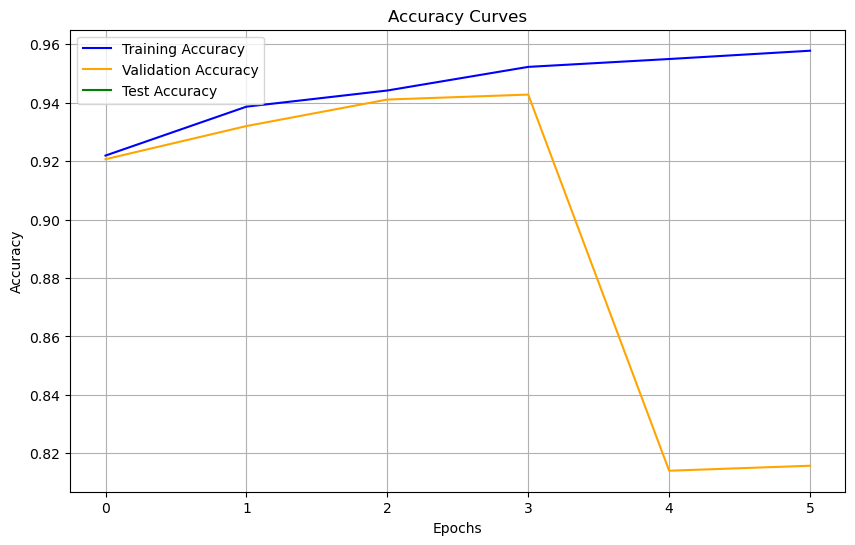

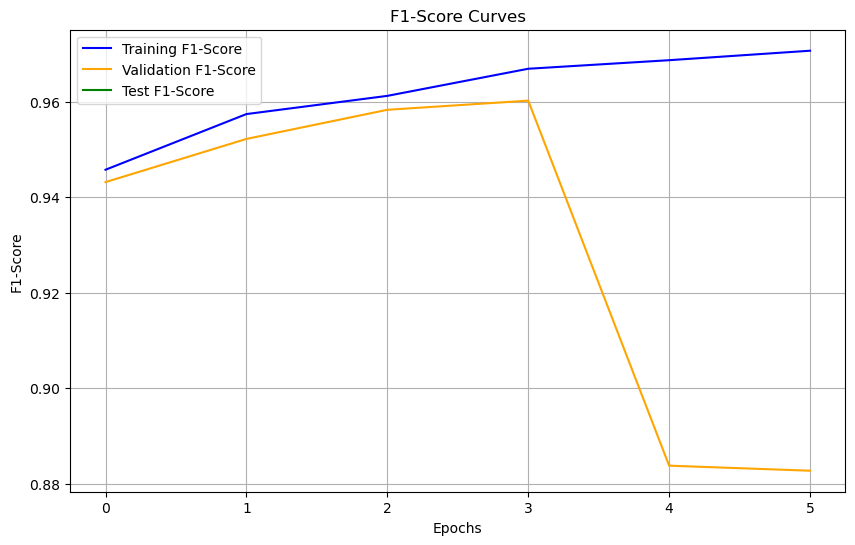

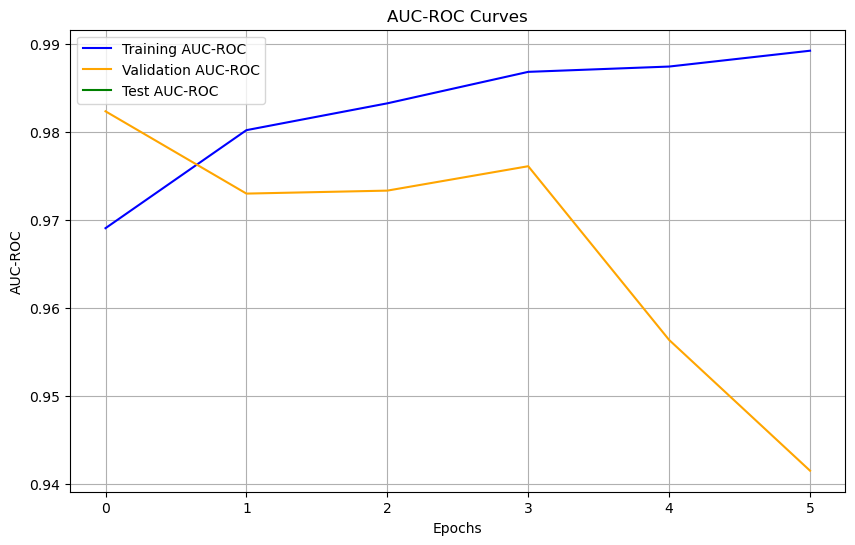

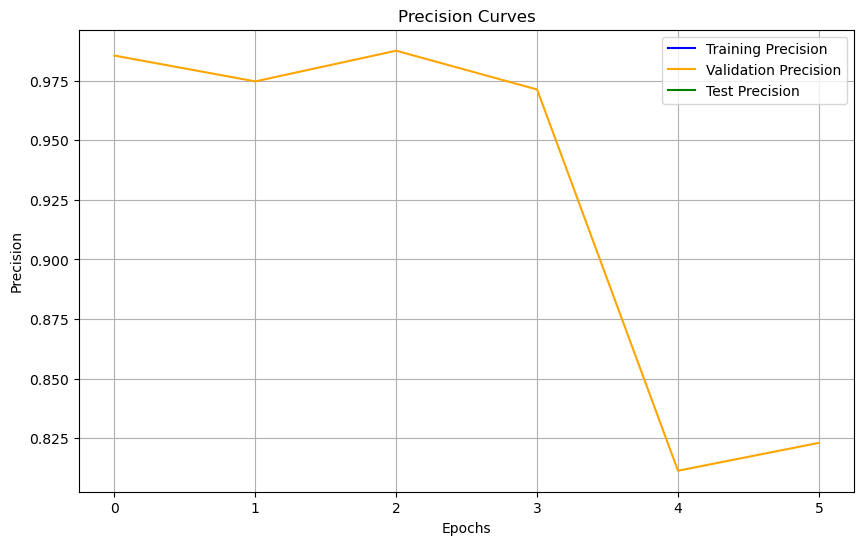

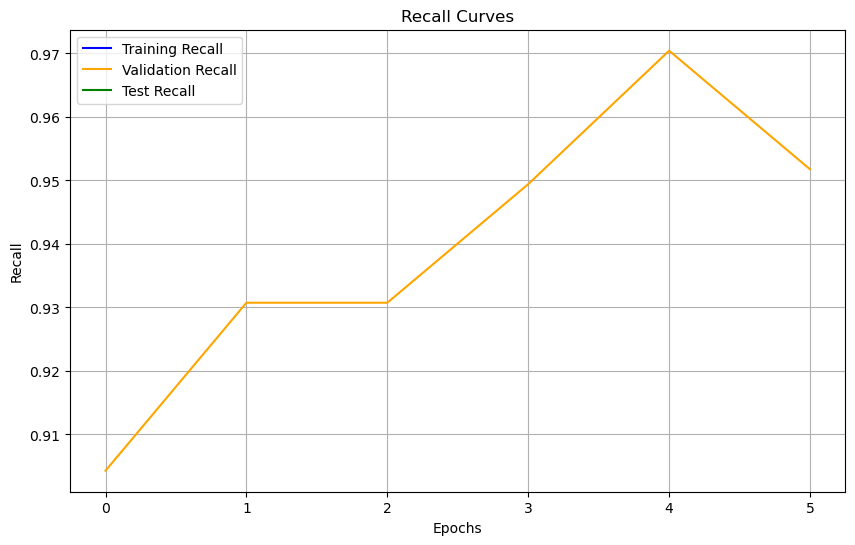

epoch,▁▂▄▅▇█
test_accuracy,▁
test_auc,▁
test_f1,▁
test_precision,▁
test_recall,▁
train_accuracy,▁▄▅▇▇█
train_auc,▁▅▆▇▇█
train_f1,▁▄▅▇▇█
train_loss,█▄▃▂▁▁
val_accuracy,▇▇██▁▁


In [8]:
config_panda = Box({
    "dataset_name": "panda-patches_512_preset-features_UNI",
    "input_feature_dim": 1024,  # Dimensionalidad de las características pre-extraídas
    "feature_dim": 128,         # Dimensionalidad final después de reducción
    "pooling_type": "max",  # Tipo de pooling (puede ser 'attention', 'mean', 'max')
    "num_epochs": 15,
    "learning_rate": 1e-3,
    "batch_size": 1,
    "val_prop": 0.2,
    "seed": 42,
    "use_inst_distances": False,
    "adj_mat_mode": "relative"
})

# Ejecutar el experimento
run_experiment(config_panda)